In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import gc
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn import metrics
import lightgbm as lgbm
from sklearn import metrics
import re
import pickle

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [116]:
df = pd.DataFrame({
    'user_id': [1, 1, 1, 1],
    'content_id': ['1', '2', '3', '2']
})

In [117]:
df.groupby('user_id').sum()

,content_id
user_id,
1,1232


# Все основные агрегаты считались в спарке

In [2]:
def memory_usage(df, name):
    mb = df.memory_usage().sum() / 1024 / 1024
    print(name + ' use {:.2f} mb in memory'.format(mb))

# TODO
* на тестах из кагловского ноутбука строчки теста начинают дублироваться. Надо бы разобарться почему. 
* submit отваливается либо на функции get_features, либо на проверке того, что датафрейм фичей не совпадает с исходным по размеру (8-й сабмит). Нужно локализовать, в чём именно проблема.
* 7-й сабмит считает скользящие признаки (самая длительная операция). Если посчитает, то идём к успеху, если нет, то придётся отказаться от количества попыток пользователя. Это несколько снижает скор на валидации, но не существенно.

# Загрузка данных

In [3]:
kaggle_data_path = './data'
#kaggle_data_path = '/kaggle/input'
# user_data_path = './data/spark_data_src'
user_data_path = './data/spark_data'
for dirname, _, filenames in os.walk(kaggle_data_path):
    for filename in filenames:
        current_file_path = os.path.join(dirname, filename)
        if 'lectures.csv' in current_file_path:
            lectures_path = current_file_path
        if 'questions.csv' in current_file_path:
            questions_path = current_file_path
        if 'train.csv' in current_file_path:
            data_path = current_file_path
#         print(current_file_path)

In [4]:
with open(os.path.join(user_data_path, 'train_data.pickle'), 'rb') as fo:
    train_data = pickle.load(fo)
memory_usage(train_data, 'train_data')
with open(os.path.join(user_data_path, 'questions_chars.pickle'), 'rb') as fo:
    question_characteristics = pickle.load(fo)
memory_usage(question_characteristics, 'question_characteristics')
with open(os.path.join(user_data_path, 'user_last_answers.pickle'), 'rb') as fo:
    last_answers = pickle.load(fo)
memory_usage(last_answers, 'user_last_answers')
with open(os.path.join(user_data_path, 'user_last_answers_valid.pickle'), 'rb') as fo:
    last_answers_valid = pickle.load(fo)
memory_usage(last_answers_valid, 'last_answers_valid')
with open(os.path.join(user_data_path, 'valid_data_table.pickle'), 'rb') as fo:
    valid_data = pickle.load(fo)
with open(os.path.join(user_data_path, 'user_accuracy.pickle'), 'rb') as fo:
    user_accuracy = pickle.load(fo)
    
memory_usage(valid_data, 'valid_data')
questions_df = pd.read_csv(questions_path)
memory_usage(questions_df, 'questions_df')

train_data use 1373.29 mb in memory
question_characteristics use 0.77 mb in memory
user_last_answers use 66.37 mb in memory
last_answers_valid use 66.35 mb in memory
valid_data use 0.85 mb in memory
questions_df use 0.52 mb in memory


In [5]:
# with open(os.path.join(user_data_path, 'train_data.pickle'), 'wb') as fo:
#     train_data['bundle_id'] = train_data['bundle_id'].astype(int)
#     train_data['part'] = train_data['part'].astype(int)
#     train_data['attempts'] = train_data['attempts'].astype(int)
#     pickle.dump(train_data, fo)

In [6]:
# with open(os.path.join(user_data_path, 'valid_data_table.pickle'), 'wb') as fo:
#     df = valid_data[['row_id', 'timestamp', 'user_id', 'content_id',
#                     'task_container_id', 'answered_correctly',
#                     'prior_question_elapsed_time', 'prior_question_had_explanation']]
#     df['content_type_id'] = 0
#     pickle.dump(df, fo)

In [7]:
# with open(os.path.join(user_data_path, 'questions_chars.pickle'), 'wb') as fo:
#     question_characteristics['bundle_id'] = question_characteristics['bundle_id'].astype(int)
#     question_characteristics['part'] = question_characteristics['part'].astype(int)
#     pickle.dump(question_characteristics, fo)

In [8]:
# with open(os.path.join(user_data_path, 'user_accuracy_valid.pickle'), 'wb') as fo:
#     df = last_answers_valid[['user_id', 'user_correct_answers_count', 'user_answers_count']]
#     df['user_accuracy'] = df['user_correct_answers_count'] / df['user_answers_count']
#     df.drop(columns=['user_answers_count', 'user_correct_answers_count'], inplace=True)
#     pickle.dump(df, fo)

In [9]:
# with open(os.path.join(user_data_path, 'user_accuracy.pickle'), 'wb') as fo:
#     df = last_answers[['user_id', 'user_correct_answers_count', 'user_answers_count']]
#     df['user_accuracy'] = df['user_correct_answers_count'] / df['user_answers_count']
#     df.drop(columns=['user_answers_count', 'user_correct_answers_count'], inplace=True)
#     pickle.dump(df.drop_duplicates(), fo)

In [10]:
# with open(os.path.join(user_data_path, 'user_last_answers_valid.pickle'), 'wb') as fo:
#     df = last_answers_valid.drop(columns=['answers_count', 'correct_answers_count', 
#                                           'explanations_count', 'tags', 'bundle_id_str',
#                                           'user_answer', 'answered_correctly', 'user_correct_answers_count']
#                         )
#     df['bundle_id'] = df['bundle_id'].astype(int)
#     df['part'] = df['part'].astype(int)
#     df['attempts'] = df['attempts'].astype(int)
#     pickle.dump(df, fo)

In [11]:
# with open(os.path.join(user_data_path, 'user_last_answers.pickle'), 'wb') as fo:
#     df = last_answers.drop(columns=['answers_count', 'correct_answers_count', 
#                                           'explanations_count', 'tags', 'bundle_id_str',
#                                           'user_answer', 'answered_correctly', 'user_correct_answers_count']
#                         )
#     df['bundle_id'] = df['bundle_id'].astype(int)
#     df['part'] = df['part'].astype(int)
#     df['attempts'] = df['attempts'].astype(int)
#     pickle.dump(df, fo)

# Формирование массива

In [12]:
def merge_data(data, questions_df):
    # Согласованность колонок теста и трейна оставляет желать лучшего
    data_columns = ['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
                    'task_container_id',
                    'prior_question_elapsed_time', 'prior_question_had_explanation']
    data = data.loc[data['content_type_id'] != 1, data_columns]
    data.drop(columns='content_type_id', inplace=True)
    
    # Собираем общий массив
    questions_df.columns = ['content_id', 'bundle_id', 'correct_answer', 'part', 'tags']
    full_df = (
        data
        .merge(questions_df, on='content_id', how='left')
    )
    
    # Заполнение наллов в просмотре ответов
    index = full_df['prior_question_had_explanation'].isnull()
    full_df.loc[index, 'prior_question_had_explanation'] = False
    
    # Приводим типы
    full_df['part'] = full_df['part'].astype('int8')
    full_df['prior_question_had_explanation'] = full_df['prior_question_had_explanation'].astype('int8')
    full_df['prior_question_elapsed_time'] = full_df['prior_question_elapsed_time'].astype('float64')

    memory_usage(full_df, 'merged_df')
    
    return full_df.drop(columns='correct_answer')

In [13]:
def get_users_last_answers(test_df, last_answers):
    user_list = list(test_df.user_id.unique())
    
    last_answers = last_answers.loc[~last_answers.user_id.isin(user_list), :]
    
    users_last_timestamps = test_df.groupby('user_id')['timestamp'].max().reset_index()
    merge_cols = ['user_id', 'timestamp']
    users_last_timestamps.columns = merge_cols
    last_answers_update = test_df.merge(users_last_timestamps, on=merge_cols, how='inner')
    
    columns = last_answers.columns
    return pd.concat([last_answers[columns], last_answers_update[columns]])

In [14]:
def get_bundles_characteristics(full_df, last_answers, q_chars):
    # У пачки вопросов временные характеристики одинаковые, нужно объединять
    group_cols = ['timestamp', 'user_id', 'bundle_id',
                  'prior_question_elapsed_time', 'prior_question_had_explanation']
    aggregates = {
        'row_id': ['count'], # количество вопросов в пачке
    }
    new_cols = group_cols + ['answers_count']
        
    bundles = full_df.groupby(group_cols, dropna=False).agg(aggregates).reset_index()
    bundles.columns = new_cols
    
    bundles['explanations_count'] = bundles['prior_question_had_explanation'] * bundles['answers_count']
    bundles.drop(columns='prior_question_had_explanation', inplace=True)
    
    # Добавляем характеристики последних ответов
    # выбираем только тех пользователей, которых считаем
    full_df_users = list(full_df.user_id.unique())
    index = last_answers['user_id'].isin(full_df_users)
    bundle_update = last_answers.loc[index, :].drop_duplicates(['user_id', 'bundle_id'])
    # переименовываем поля
    bundle_update.loc[:, 'prior_question_elapsed_time'] = bundle_update.loc[:, 'user_elapsed_time']
    bundle_update.loc[:, 'answers_count'] = bundle_update.loc[:, 'user_answers_count']
    bundle_update.loc[:, 'explanations_count'] = bundle_update.loc[:, 'user_explanation_count']
    bundle_update.loc[:, 'prior_question_delay'] = bundle_update.loc[:, 'user_total_delay']
    # поле ответов пользователя
    bundles['bundle_id_str'] = ' ' + bundles['bundle_id'].astype(str) + ','
    bundle_update.loc[:, 'bundle_id_str'] = bundle_update.loc[:, 'user_bundles_list']
    # присоединяем
    bundle_update_columns = list(bundles.columns) + ['prior_question_delay']
    bundles = pd.concat([bundle_update[bundle_update_columns], bundles])
    bundles = bundles.sort_values(['user_id', 'timestamp'])
    
    # Считаем задержки пользователей на ответ
    bundles['prior_bundle_id'] = (
        bundles
        .groupby(['user_id'])['bundle_id'].shift(1)
        .fillna(-1).astype(int)
    )
    q_chars_time = q_chars.groupby('bundle_id')['question_elapsed_time_mean'].mean().reset_index()
    q_chars_time.columns = ['prior_bundle_id', 'prior_question_elapsed_time_mean']
    bundles = bundles.merge(q_chars_time, on='prior_bundle_id', how='left')
    index = bundles['prior_question_delay'].isnull()
    bundles.loc[index, 'prior_question_delay'] = (bundles.loc[index, 'prior_question_elapsed_time'] - bundles.loc[index, 'prior_question_elapsed_time_mean']) / bundles.loc[index, 'prior_question_elapsed_time_mean']
    bundles.drop(columns=['prior_bundle_id', 'prior_question_elapsed_time_mean'], inplace=True) 
    
    return bundles

In [15]:
def append_bundles_characteristics(full_df, bundles):
    # Сортируем по таймстемпу, чтобы потом нигде этим не заниматься
    bundles = bundles.sort_values(['user_id', 'timestamp'], ascending=True)
    
#     print('start kraken')
#     # пачки, на которые пользователь уже отвечал
#     for user_id in bundles.user_id.unique():
#         index = bundles['user_id'] == user_id
#         bundles.loc[index, 'user_bundles_list'] = bundles.loc[index, 'bundle_id_str'].cumsum()
#     print('end kraken')
    print('start kraken')
    bundles['user_bundles_list'] = bundles.groupby('user_id')['bundle_id_str'].apply(lambda x: x.cumsum())
    print('end kraken')
    
    # Ищем номер попытки ответа именно на этот вопрос (нумерация с нуля)
    bundles['attempts'] = bundles.apply(lambda x: len(re.findall(' ' + str(x.bundle_id) + ',', x.user_bundles_list)), axis=1).astype('int8')
    print('end attempts')
    
    # Количество объяснений, которые получил пользователь
    bundles['user_explanation_count'] = bundles\
                                        .groupby(['user_id'])['explanations_count']\
                                        .cumsum()
    
    # Сумарное время ответов с начала теста до ответа на текущий вопрос
    bundles['user_elapsed_time'] = bundles\
                                   .groupby(['user_id'])['prior_question_elapsed_time']\
                                   .cumsum()
    # Количество ответов пользователя до текущего момента
    bundles['user_answers_count'] = bundles\
                                    .groupby(['user_id'])['answers_count']\
                                    .cumsum()
    
    # Суммарная средняя задержка
    bundles['user_total_delay'] = bundles\
                                    .groupby(['user_id'])['prior_question_delay']\
                                    .cumsum()
    
    # Добавляем признаки к исходному массиву
    merge_cols = ['user_id', 'bundle_id']
    bundle_cols = merge_cols + ['user_bundles_list', 'attempts', 'user_explanation_count', 
                                'user_elapsed_time', 'user_answers_count', 'user_total_delay']
    full_df = full_df.merge(bundles[bundle_cols], on=merge_cols, how='left')
        
    memory_usage(full_df, 'full_df')
    
    return full_df

In [16]:
def get_characteristics(test_df, questions_df, last_answers, q_chars, user_accuracy):
    merged_df = merge_data(test_df, questions_df)
    bundles = get_bundles_characteristics(merged_df, last_answers, q_chars)
    test_df_expand = append_bundles_characteristics(merged_df, bundles)
    
    last_answers = get_users_last_answers(test_df_expand, last_answers)
    output = (
        test_df_expand
        .merge(q_chars.drop(columns=['bundle_id', 'part']), on='content_id', how='left')
        .merge(user_accuracy, on='user_id', how='left')
    )
    memory_usage(output, 'test_df')
    memory_usage(last_answers, 'last_answers')
    
    return output, last_answers

In [24]:
%%time
valid_df, _ = get_characteristics(valid_data, questions_df, last_answers_valid, question_characteristics, user_accuracy)

merged_df use 1.14 mb in memory
start kraken
end kraken
end attempts
full_df use 1.68 mb in memory
test_df use 6.46 mb in memory
last_answers use 71.48 mb in memory
CPU times: user 2.45 s, sys: 153 ms, total: 2.6 s
Wall time: 2.57 s


In [9]:
# valid_df.drop(columns=['timestamp', 'user_id', 'content_id', 'task_container_id', 
#                                     'prior_question_elapsed_time', 'prior_question_had_explanation', 'bundle_id', 
#                                     'tags', 'user_bundles_list'])

# Подготовка признаков

In [17]:
def norm_column(df, col):
    min_val = df[col].min()
    max_val = df[col].max()
    delta_val = max_val - min_val + 0.00001
    df.loc[:, col] = (df.loc[:, col] - min_val) / delta_val
    return df
def get_features_df(users_df, q_chars):
    output = users_df.drop(columns=['timestamp', 'user_id', 'content_id', 'task_container_id', 
                                    'prior_question_elapsed_time', 'prior_question_had_explanation', 'bundle_id', 
                                    'tags', 'user_bundles_list'])
    # Ограничиваем количество попыток
    output.loc[:, 'attempts'] -= 1
    output.loc[output['attempts'] > 4, 'attempts'] = 4
    
    # Процент полученных объяснений
    output.loc[:, 'user_explanation_rate'] = output.loc[:, 'user_explanation_count'] / output.loc[:, 'user_answers_count']
    index = output.loc[:, 'user_explanation_rate'].isnull()
    output.loc[index, 'user_explanation_rate'] = 0.5
    
    # Заполнение подсказок вопроса
    index = output.loc[:, 'question_had_explanation_mean'].isnull()
    output.loc[index, 'question_had_explanation_mean'] = 0.5
    
    # Гармоническое среднее процента полученных посказок
    output.loc[:, 'user_explanation_rate_hmean'] = output.loc[:, 'user_explanation_rate'] * output.loc[:, 'question_had_explanation_mean'] / (output.loc[:, 'user_explanation_rate'] + output.loc[:, 'question_had_explanation_mean'])
    
    # Среднее время потраченное на вопрос
    output.loc[:, 'user_elapsed_time_mean'] = output.loc[:, 'user_elapsed_time'] / output.loc[:, 'user_answers_count']
    index = output.loc[:, 'user_elapsed_time_mean'].isnull()
    mean_elapsed_time = q_chars.loc[:, 'question_elapsed_time_mean'].mean()
    output.loc[index, 'user_elapsed_time_mean'] = mean_elapsed_time
    output = norm_column(output, 'user_elapsed_time_mean')
    
    # Нормированное количество ответов пользователя
    output.loc[:, 'user_answers_count_norm'] = output.loc[:, 'user_answers_count']
    output = norm_column(output, 'user_answers_count_norm')
    
    # Средняя задержка пользователя при ответе на вопросы
    output.loc[:, 'user_delay_mean'] = output.loc[:, 'user_total_delay'] / output.loc[:, 'user_answers_count']
    index = output.loc[:, 'user_delay_mean'].isnull()
    output.loc[index, 'user_delay_mean'] = 0.
    output = norm_column(output, 'user_delay_mean')
    
    # Нормированное суммарное количество ответов на конкретный вопрос
    output.loc[:, 'question_answers_count_norm'] = output.loc[:, 'question_answers_count']
    output = norm_column(output, 'question_answers_count_norm')
    index = output.loc[:, 'question_answers_count_norm'].isnull()
    output.loc[index, 'question_answers_count_norm'] = 0
    
    # Заполнение правильности ответа на вопрос
    index = output.loc[:, 'question_correct_answers_mean'].isnull()
    output.loc[index, 'question_correct_answers_mean'] = 0.5
    
    # Заполнение сложности вопроса
    index = output.loc[:, 'question_user_var'].isnull()
    output.loc[index, 'question_user_var'] = 1.0
    
    # Среднее время потраченное на вопрос всеми пользователями
    index = output.loc[:, 'question_elapsed_time_mean'].isnull()
    mean_elapsed_time = q_chars.loc[:, 'question_elapsed_time_mean'].mean()
    output.loc[index, 'question_elapsed_time_mean'] = mean_elapsed_time
    output = norm_column(output, 'question_elapsed_time_mean')
    
    # Гармоническое среднее между точностью ответов пользователя и точностью ответов на вопрос
    output.loc[:, 'user_accuracy_hmean'] = output.loc[:, 'user_accuracy'] * output.loc[:, 'question_correct_answers_mean'] / (output.loc[:, 'user_accuracy'] + output.loc[:, 'question_correct_answers_mean'])
    index = output.loc[:, 'user_accuracy_hmean'].isnull()
    mean_accuracy = q_chars.loc[:, 'question_elapsed_time_mean'].mean()
    output.loc[index, 'user_accuracy_hmean'] = 0.5
    
    # Номер строчки в индексы
    output = output.set_index('row_id')
    
    features_columns = ['part', 'attempts', 'user_explanation_rate_hmean', 'question_had_explanation_mean',
                        'user_elapsed_time_mean', 'user_answers_count_norm', 'user_delay_mean',
                        'question_answers_count_norm', 'user_accuracy_hmean', 'question_correct_answers_mean',
                        'question_user_var', 'question_elapsed_time_mean']
    
    output = output.loc[:, features_columns]
    
    memory_usage(output, 'combined_df')
    
    return output

## Формируем признаки

In [20]:
%%time
# Заготовки для признаков
valid_data_expand, _ = get_characteristics(valid_data, questions_df, last_answers_valid, question_characteristics, user_accuracy)

train_data_expand = (
    train_data
    .merge(question_characteristics.drop(columns=['bundle_id', 'part']), on='content_id', how='left')
    .merge(user_accuracy, on='user_id', how='left')
)
train_data_expand.loc[:, 'user_bundles_list'] = 0.

merged_df use 1.14 mb in memory
start kraken
end kraken
end attempts
full_df use 1.68 mb in memory
test_df use 6.46 mb in memory
last_answers use 71.48 mb in memory
CPU times: user 23.1 s, sys: 7.87 s, total: 30.9 s
Wall time: 29.5 s


In [25]:
%%time
# Выборки
valid_df = get_features_df(valid_data_expand, question_characteristics)
train_df = get_features_df(train_data_expand, question_characteristics)

combined_df use 3.81 mb in memory
combined_df use 1504.04 mb in memory
CPU times: user 19.5 s, sys: 16.7 s, total: 36.2 s
Wall time: 35.6 s


In [26]:
%%time
# Верные ответы
valid_df = valid_df.reset_index().merge(valid_data.loc[:, ['row_id', 'answered_correctly']], on='row_id', how='inner').set_index('row_id')
train_df = train_df.reset_index().merge(train_data.loc[:, ['row_id', 'answered_correctly']], on='row_id', how='inner').set_index('row_id')

CPU times: user 6.47 s, sys: 4.38 s, total: 10.8 s
Wall time: 11.2 s


In [99]:
with open(os.path.join(user_data_path, 'train_df.pickle'), 'wb') as fo:
    pickle.dump(train_df, fo)
with open(os.path.join(user_data_path, 'valid_df.pickle'), 'wb') as fo:
    pickle.dump(valid_df, fo)

In [119]:
valid_df

,part,attempts,user_explanation_rate_hmean,question_had_explanation_mean,user_elapsed_time_mean,user_answers_count_norm,user_delay_mean,question_answers_count_norm,user_accuracy_hmean,question_correct_answers_mean,question_user_var,question_elapsed_time_mean,answered_correctly_x,answered_correctly_y
row_id,,,,,,,,,,,,,,
79300337,5,0,0.236579,0.983879,0.194462,0.003711,0.300512,0.078493,0.317102,0.735597,0.885195,0.298411,1,1
79431057,7,0,0.000000,0.079464,0.119233,0.001794,0.262100,0.750427,0.109374,0.608665,0.968802,0.452992,0,0
79431057,7,0,0.000000,0.079464,0.119233,0.001794,0.262100,0.750427,0.109374,0.608665,0.968802,0.452992,0,0
79431057,7,0,0.000000,0.079464,0.119233,0.001794,0.262100,0.750427,0.109374,0.608665,0.968802,0.452992,0,0
79431057,7,0,0.000000,0.079464,0.119233,0.001794,0.262100,0.750427,0.109374,0.608665,0.968802,0.452992,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94743104,2,0,0.364743,0.985823,0.165847,0.001113,0.221386,0.045588,0.339023,0.818079,0.844522,0.149426,1,1
94790055,5,1,0.476143,0.988806,0.141556,0.006000,0.159171,0.208311,0.265429,0.468570,0.792842,0.551746,0,0
94865108,2,0,0.433464,0.993051,0.157222,0.003154,0.191770,0.006667,0.428454,0.938366,0.966759,0.116842,1,1


# Обучение модели

In [18]:
with open(os.path.join(user_data_path, 'train_df.pickle'), 'rb') as fo:
    train_df = pickle.load(fo)
with open(os.path.join(user_data_path, 'valid_df.pickle'), 'rb') as fo:
    valid_df = pickle.load(fo)
with open(os.path.join(user_data_path, 'user_last_answers.pickle'), 'rb') as fo:
    last_answers = pickle.load(fo)
with open(os.path.join(user_data_path, 'questions_chars.pickle'), 'rb') as fo:
    q_chars = pickle.load(fo)
with open(os.path.join(user_data_path, 'user_accuracy.pickle'), 'rb') as fo:
    user_accuracy = pickle.load(fo).drop_duplicates()
questions_df = pd.read_csv(questions_path)
    
memory_usage(train_df, 'train_df')
memory_usage(valid_df, 'valid_df')
memory_usage(q_chars, 'question_characteristics')
memory_usage(last_answers, 'user_last_answers')
memory_usage(user_accuracy, 'user_accuracy')
memory_usage(questions_df, 'questions_df')

train_df use 1692.05 mb in memory
valid_df use 4.02 mb in memory
question_characteristics use 0.77 mb in memory
user_last_answers use 66.37 mb in memory
user_accuracy use 7.51 mb in memory
questions_df use 0.52 mb in memory


In [111]:
lgbm_train = lgbm.Dataset(data = train_df.drop(columns='answered_correctly'),#.iloc[:1000000, :],
                          label = train_df.loc[:, 'answered_correctly'],#.iloc[:1000000],
                          categorical_feature=[0],
                          free_raw_data = False)

lgbm_valid = lgbm.Dataset(data = valid_df.drop(columns='answered_correctly'),
                          label = valid_df.loc[:, 'answered_correctly'],
                          categorical_feature=[0],
                          free_raw_data = False)

# Поиск по сетке параметров

In [20]:
def combine_parameters(static_parameters, dynamic_parameters):
    """
    Фнкция составления списка наборов параметров из заданного словаря
    """
    if not dynamic_parameters:
        return static_parameters

    keys = list(dynamic_parameters.keys())
    settings = []

    if len(keys) == 1:
        key = keys[0]
        current_settings = static_parameters
        for param in dynamic_parameters[key]:
            current_settings[key] = param
            settings.append(current_settings.copy())
    else:
        key = keys[0]
        current_settings = static_parameters
        current_dyn_params = dict([(name, val) for name, val in dynamic_parameters.items() if name != key])
        for param in dynamic_parameters[key]:
            current_settings[key] = param

            current_parameters = combine_parameters(current_settings.copy(), current_dyn_params)
            settings += current_parameters

    return settings

In [107]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 38,
          'learning_rate': 0.1,
          'n_estimators': 100,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.8,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 0.01,
          'reg_lambda': 20,
          'metric' : 'auc',
          'random_state': 17}

gridParams = {
    'learning_rate': [0.05, 0.1, 0.15],
    'num_leaves': [30, 40, 50],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [15, 20, 25],
    }
# NUM_BOOST_ROUND = 2500
# VERBOSE_EVAL = 25

# mdl = lgbm.LGBMClassifier(boosting_type= 'gbdt',
#                         objective = 'binary',
#                         n_jobs = 3, # Updated from 'nthread'
#                         silent = True,
#                         max_depth = params['max_depth'],
#                         max_bin = params['max_bin'],
#                         subsample_for_bin = params['subsample_for_bin'],
#                         subsample = params['subsample'],
#                         subsample_freq = params['subsample_freq'],
#                         min_split_gain = params['min_split_gain'],
#                         min_child_weight = params['min_child_weight'],
#                         min_child_samples = params['min_child_samples'],
#                         scale_pos_weight = params['scale_pos_weight'])
# grid = GridSearchCV(mdl, gridParams,
#                     verbose=0,
#                     cv=4,
#                     n_jobs=2)

In [108]:
score_list = []
param_list = combine_parameters(params, gridParams)

for current_params in param_list:
    model = lgbm.train(params=current_params, train_set = lgbm_train, valid_sets = [lgbm_valid])
    y_predict = model.predict(lgbm_valid.data)
    score_list.append(metrics.roc_auc_score(lgbm_valid.label, y_predict))

[1]	valid_0's auc: 0.758835
[2]	valid_0's auc: 0.762406
[3]	valid_0's auc: 0.756476
[4]	valid_0's auc: 0.760307
[5]	valid_0's auc: 0.762307
[6]	valid_0's auc: 0.76387
[7]	valid_0's auc: 0.764093
[8]	valid_0's auc: 0.765078
[9]	valid_0's auc: 0.765462
[10]	valid_0's auc: 0.76556
[11]	valid_0's auc: 0.76605
[12]	valid_0's auc: 0.766586
[13]	valid_0's auc: 0.76669
[14]	valid_0's auc: 0.766927
[15]	valid_0's auc: 0.767191
[16]	valid_0's auc: 0.767232
[17]	valid_0's auc: 0.767438
[18]	valid_0's auc: 0.768119
[19]	valid_0's auc: 0.768057
[20]	valid_0's auc: 0.768178
[21]	valid_0's auc: 0.768342
[22]	valid_0's auc: 0.768461
[23]	valid_0's auc: 0.768503
[24]	valid_0's auc: 0.767777
[25]	valid_0's auc: 0.768066
[26]	valid_0's auc: 0.768234
[27]	valid_0's auc: 0.768273
[28]	valid_0's auc: 0.768428
[29]	valid_0's auc: 0.768436
[30]	valid_0's auc: 0.768698
[31]	valid_0's auc: 0.768751
[32]	valid_0's auc: 0.768796
[33]	valid_0's auc: 0.768791
[34]	valid_0's auc: 0.768426
[35]	valid_0's auc: 0.76853

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.757749
[2]	valid_0's auc: 0.762414
[3]	valid_0's auc: 0.755804
[4]	valid_0's auc: 0.760071
[5]	valid_0's auc: 0.76202
[6]	valid_0's auc: 0.763772
[7]	valid_0's auc: 0.763921
[8]	valid_0's auc: 0.764917
[9]	valid_0's auc: 0.765259
[10]	valid_0's auc: 0.765454
[11]	valid_0's auc: 0.765932
[12]	valid_0's auc: 0.766547
[13]	valid_0's auc: 0.766639
[14]	valid_0's auc: 0.766972
[15]	valid_0's auc: 0.767216
[16]	valid_0's auc: 0.766943
[17]	valid_0's auc: 0.767105
[18]	valid_0's auc: 0.767779
[19]	valid_0's auc: 0.767916
[20]	valid_0's auc: 0.767824
[21]	valid_0's auc: 0.768056
[22]	valid_0's auc: 0.767999
[23]	valid_0's auc: 0.768109
[24]	valid_0's auc: 0.767423
[25]	valid_0's auc: 0.767535
[26]	valid_0's auc: 0.767803
[27]	valid_0's auc: 0.767806
[28]	valid_0's auc: 0.768082
[29]	valid_0's auc: 0.76808
[30]	valid_0's auc: 0.768317
[31]	valid_0's auc: 0.768441
[32]	valid_0's auc: 0.768584
[33]	valid_0's auc: 0.768516
[34]	valid_0's auc: 0.768284
[35]	valid_0's auc: 0.768

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.756171
[2]	valid_0's auc: 0.762273
[3]	valid_0's auc: 0.755463
[4]	valid_0's auc: 0.759917
[5]	valid_0's auc: 0.761903
[6]	valid_0's auc: 0.763723
[7]	valid_0's auc: 0.763865
[8]	valid_0's auc: 0.764874
[9]	valid_0's auc: 0.76531
[10]	valid_0's auc: 0.765465
[11]	valid_0's auc: 0.765966
[12]	valid_0's auc: 0.766551
[13]	valid_0's auc: 0.766669
[14]	valid_0's auc: 0.766924
[15]	valid_0's auc: 0.767137
[16]	valid_0's auc: 0.767204
[17]	valid_0's auc: 0.767296
[18]	valid_0's auc: 0.768191
[19]	valid_0's auc: 0.768314
[20]	valid_0's auc: 0.768394
[21]	valid_0's auc: 0.768503
[22]	valid_0's auc: 0.768442
[23]	valid_0's auc: 0.76829
[24]	valid_0's auc: 0.76755
[25]	valid_0's auc: 0.76775
[26]	valid_0's auc: 0.767934
[27]	valid_0's auc: 0.768057
[28]	valid_0's auc: 0.768516
[29]	valid_0's auc: 0.768753
[30]	valid_0's auc: 0.768934
[31]	valid_0's auc: 0.768931
[32]	valid_0's auc: 0.769037
[33]	valid_0's auc: 0.769273
[34]	valid_0's auc: 0.768891
[35]	valid_0's auc: 0.76898

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758835
[2]	valid_0's auc: 0.762406
[3]	valid_0's auc: 0.756476
[4]	valid_0's auc: 0.760307
[5]	valid_0's auc: 0.762307
[6]	valid_0's auc: 0.76387
[7]	valid_0's auc: 0.764093
[8]	valid_0's auc: 0.765078
[9]	valid_0's auc: 0.765462
[10]	valid_0's auc: 0.76556
[11]	valid_0's auc: 0.76605
[12]	valid_0's auc: 0.766587
[13]	valid_0's auc: 0.76669
[14]	valid_0's auc: 0.766927
[15]	valid_0's auc: 0.767191
[16]	valid_0's auc: 0.767232
[17]	valid_0's auc: 0.767438
[18]	valid_0's auc: 0.768119
[19]	valid_0's auc: 0.768057
[20]	valid_0's auc: 0.768178
[21]	valid_0's auc: 0.768342
[22]	valid_0's auc: 0.768461
[23]	valid_0's auc: 0.768503
[24]	valid_0's auc: 0.767778
[25]	valid_0's auc: 0.768066
[26]	valid_0's auc: 0.768235
[27]	valid_0's auc: 0.768273
[28]	valid_0's auc: 0.768428
[29]	valid_0's auc: 0.768436
[30]	valid_0's auc: 0.768698
[31]	valid_0's auc: 0.768752
[32]	valid_0's auc: 0.768796
[33]	valid_0's auc: 0.768791
[34]	valid_0's auc: 0.768426
[35]	valid_0's auc: 0.76853

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.757749
[2]	valid_0's auc: 0.762414
[3]	valid_0's auc: 0.755804
[4]	valid_0's auc: 0.760071
[5]	valid_0's auc: 0.76202
[6]	valid_0's auc: 0.763772
[7]	valid_0's auc: 0.763921
[8]	valid_0's auc: 0.764917
[9]	valid_0's auc: 0.765259
[10]	valid_0's auc: 0.765455
[11]	valid_0's auc: 0.765932
[12]	valid_0's auc: 0.766547
[13]	valid_0's auc: 0.766639
[14]	valid_0's auc: 0.766972
[15]	valid_0's auc: 0.767216
[16]	valid_0's auc: 0.766943
[17]	valid_0's auc: 0.767105
[18]	valid_0's auc: 0.767779
[19]	valid_0's auc: 0.767916
[20]	valid_0's auc: 0.767824
[21]	valid_0's auc: 0.768056
[22]	valid_0's auc: 0.767999
[23]	valid_0's auc: 0.768109
[24]	valid_0's auc: 0.767423
[25]	valid_0's auc: 0.767535
[26]	valid_0's auc: 0.767803
[27]	valid_0's auc: 0.767808
[28]	valid_0's auc: 0.768082
[29]	valid_0's auc: 0.76808
[30]	valid_0's auc: 0.768317
[31]	valid_0's auc: 0.768442
[32]	valid_0's auc: 0.768584
[33]	valid_0's auc: 0.768516
[34]	valid_0's auc: 0.768284
[35]	valid_0's auc: 0.768

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.756171
[2]	valid_0's auc: 0.762273
[3]	valid_0's auc: 0.755463
[4]	valid_0's auc: 0.759917
[5]	valid_0's auc: 0.761903
[6]	valid_0's auc: 0.763723
[7]	valid_0's auc: 0.763865
[8]	valid_0's auc: 0.764873
[9]	valid_0's auc: 0.76531
[10]	valid_0's auc: 0.765465
[11]	valid_0's auc: 0.765966
[12]	valid_0's auc: 0.766551
[13]	valid_0's auc: 0.766669
[14]	valid_0's auc: 0.766924
[15]	valid_0's auc: 0.767137
[16]	valid_0's auc: 0.767204
[17]	valid_0's auc: 0.767296
[18]	valid_0's auc: 0.768191
[19]	valid_0's auc: 0.768314
[20]	valid_0's auc: 0.768394
[21]	valid_0's auc: 0.768503
[22]	valid_0's auc: 0.768442
[23]	valid_0's auc: 0.76829
[24]	valid_0's auc: 0.767549
[25]	valid_0's auc: 0.76775
[26]	valid_0's auc: 0.767934
[27]	valid_0's auc: 0.768057
[28]	valid_0's auc: 0.768516
[29]	valid_0's auc: 0.768753
[30]	valid_0's auc: 0.768934
[31]	valid_0's auc: 0.768931
[32]	valid_0's auc: 0.769037
[33]	valid_0's auc: 0.769273
[34]	valid_0's auc: 0.768891
[35]	valid_0's auc: 0.7689

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758835
[2]	valid_0's auc: 0.762406
[3]	valid_0's auc: 0.756476
[4]	valid_0's auc: 0.760308
[5]	valid_0's auc: 0.762307
[6]	valid_0's auc: 0.763868
[7]	valid_0's auc: 0.764093
[8]	valid_0's auc: 0.765079
[9]	valid_0's auc: 0.765459
[10]	valid_0's auc: 0.765554
[11]	valid_0's auc: 0.766048
[12]	valid_0's auc: 0.766587
[13]	valid_0's auc: 0.76669
[14]	valid_0's auc: 0.766926
[15]	valid_0's auc: 0.76719
[16]	valid_0's auc: 0.767231
[17]	valid_0's auc: 0.767437
[18]	valid_0's auc: 0.768118
[19]	valid_0's auc: 0.768057
[20]	valid_0's auc: 0.768179
[21]	valid_0's auc: 0.768344
[22]	valid_0's auc: 0.768461
[23]	valid_0's auc: 0.768503
[24]	valid_0's auc: 0.767777
[25]	valid_0's auc: 0.768066
[26]	valid_0's auc: 0.768234
[27]	valid_0's auc: 0.768272
[28]	valid_0's auc: 0.768427
[29]	valid_0's auc: 0.768435
[30]	valid_0's auc: 0.768695
[31]	valid_0's auc: 0.768752
[32]	valid_0's auc: 0.768795
[33]	valid_0's auc: 0.768789
[34]	valid_0's auc: 0.768424
[35]	valid_0's auc: 0.768

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.757749
[2]	valid_0's auc: 0.762414
[3]	valid_0's auc: 0.7558
[4]	valid_0's auc: 0.76007
[5]	valid_0's auc: 0.76202
[6]	valid_0's auc: 0.763772
[7]	valid_0's auc: 0.763921
[8]	valid_0's auc: 0.764921
[9]	valid_0's auc: 0.765259
[10]	valid_0's auc: 0.765468
[11]	valid_0's auc: 0.765965
[12]	valid_0's auc: 0.766577
[13]	valid_0's auc: 0.766658
[14]	valid_0's auc: 0.767009
[15]	valid_0's auc: 0.767218
[16]	valid_0's auc: 0.766932
[17]	valid_0's auc: 0.767175
[18]	valid_0's auc: 0.76784
[19]	valid_0's auc: 0.76799
[20]	valid_0's auc: 0.767989
[21]	valid_0's auc: 0.768194
[22]	valid_0's auc: 0.768183
[23]	valid_0's auc: 0.768202
[24]	valid_0's auc: 0.767437
[25]	valid_0's auc: 0.767632
[26]	valid_0's auc: 0.767743
[27]	valid_0's auc: 0.767906
[28]	valid_0's auc: 0.768195
[29]	valid_0's auc: 0.768271
[30]	valid_0's auc: 0.768513
[31]	valid_0's auc: 0.768514
[32]	valid_0's auc: 0.768662
[33]	valid_0's auc: 0.768806
[34]	valid_0's auc: 0.76852
[35]	valid_0's auc: 0.768745
[

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.756171
[2]	valid_0's auc: 0.762273
[3]	valid_0's auc: 0.755467
[4]	valid_0's auc: 0.759917
[5]	valid_0's auc: 0.761903
[6]	valid_0's auc: 0.763718
[7]	valid_0's auc: 0.763866
[8]	valid_0's auc: 0.764873
[9]	valid_0's auc: 0.76531
[10]	valid_0's auc: 0.765465
[11]	valid_0's auc: 0.765966
[12]	valid_0's auc: 0.766551
[13]	valid_0's auc: 0.766669
[14]	valid_0's auc: 0.766924
[15]	valid_0's auc: 0.767136
[16]	valid_0's auc: 0.767205
[17]	valid_0's auc: 0.767296
[18]	valid_0's auc: 0.768191
[19]	valid_0's auc: 0.768312
[20]	valid_0's auc: 0.768391
[21]	valid_0's auc: 0.7685
[22]	valid_0's auc: 0.768441
[23]	valid_0's auc: 0.768289
[24]	valid_0's auc: 0.767549
[25]	valid_0's auc: 0.767749
[26]	valid_0's auc: 0.767934
[27]	valid_0's auc: 0.768055
[28]	valid_0's auc: 0.768516
[29]	valid_0's auc: 0.768753
[30]	valid_0's auc: 0.768933
[31]	valid_0's auc: 0.768933
[32]	valid_0's auc: 0.769038
[33]	valid_0's auc: 0.769273
[34]	valid_0's auc: 0.768888
[35]	valid_0's auc: 0.7689

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.760124
[2]	valid_0's auc: 0.763572
[3]	valid_0's auc: 0.757202
[4]	valid_0's auc: 0.761027
[5]	valid_0's auc: 0.763356
[6]	valid_0's auc: 0.765028
[7]	valid_0's auc: 0.765248
[8]	valid_0's auc: 0.765643
[9]	valid_0's auc: 0.765778
[10]	valid_0's auc: 0.766091
[11]	valid_0's auc: 0.766596
[12]	valid_0's auc: 0.767238
[13]	valid_0's auc: 0.767629
[14]	valid_0's auc: 0.767893
[15]	valid_0's auc: 0.768082
[16]	valid_0's auc: 0.767924
[17]	valid_0's auc: 0.767932
[18]	valid_0's auc: 0.768385
[19]	valid_0's auc: 0.768562
[20]	valid_0's auc: 0.768592
[21]	valid_0's auc: 0.768684
[22]	valid_0's auc: 0.768808
[23]	valid_0's auc: 0.768809
[24]	valid_0's auc: 0.768154
[25]	valid_0's auc: 0.768367
[26]	valid_0's auc: 0.768575
[27]	valid_0's auc: 0.76875
[28]	valid_0's auc: 0.768531
[29]	valid_0's auc: 0.768737
[30]	valid_0's auc: 0.768942
[31]	valid_0's auc: 0.769057
[32]	valid_0's auc: 0.769202
[33]	valid_0's auc: 0.769385
[34]	valid_0's auc: 0.768995
[35]	valid_0's auc: 0.76

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758806
[2]	valid_0's auc: 0.763262
[3]	valid_0's auc: 0.75645
[4]	valid_0's auc: 0.760813
[5]	valid_0's auc: 0.762735
[6]	valid_0's auc: 0.764212
[7]	valid_0's auc: 0.764596
[8]	valid_0's auc: 0.764793
[9]	valid_0's auc: 0.765106
[10]	valid_0's auc: 0.765655
[11]	valid_0's auc: 0.76624
[12]	valid_0's auc: 0.766571
[13]	valid_0's auc: 0.767694
[14]	valid_0's auc: 0.768011
[15]	valid_0's auc: 0.7682
[16]	valid_0's auc: 0.768114
[17]	valid_0's auc: 0.768267
[18]	valid_0's auc: 0.768146
[19]	valid_0's auc: 0.768452
[20]	valid_0's auc: 0.768657
[21]	valid_0's auc: 0.768671
[22]	valid_0's auc: 0.768724
[23]	valid_0's auc: 0.768635
[24]	valid_0's auc: 0.767909
[25]	valid_0's auc: 0.768167
[26]	valid_0's auc: 0.768423
[27]	valid_0's auc: 0.768582
[28]	valid_0's auc: 0.768631
[29]	valid_0's auc: 0.768871
[30]	valid_0's auc: 0.768984
[31]	valid_0's auc: 0.769094
[32]	valid_0's auc: 0.7692
[33]	valid_0's auc: 0.769258
[34]	valid_0's auc: 0.768822
[35]	valid_0's auc: 0.768989


/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758799
[2]	valid_0's auc: 0.763258
[3]	valid_0's auc: 0.75645
[4]	valid_0's auc: 0.760406
[5]	valid_0's auc: 0.762716
[6]	valid_0's auc: 0.764224
[7]	valid_0's auc: 0.764533
[8]	valid_0's auc: 0.764883
[9]	valid_0's auc: 0.765067
[10]	valid_0's auc: 0.765672
[11]	valid_0's auc: 0.766302
[12]	valid_0's auc: 0.767
[13]	valid_0's auc: 0.767719
[14]	valid_0's auc: 0.76785
[15]	valid_0's auc: 0.768189
[16]	valid_0's auc: 0.76783
[17]	valid_0's auc: 0.768033
[18]	valid_0's auc: 0.768627
[19]	valid_0's auc: 0.76873
[20]	valid_0's auc: 0.768787
[21]	valid_0's auc: 0.768926
[22]	valid_0's auc: 0.769098
[23]	valid_0's auc: 0.768981
[24]	valid_0's auc: 0.768159
[25]	valid_0's auc: 0.768403
[26]	valid_0's auc: 0.76872
[27]	valid_0's auc: 0.76885
[28]	valid_0's auc: 0.768815
[29]	valid_0's auc: 0.768711
[30]	valid_0's auc: 0.76891
[31]	valid_0's auc: 0.769042
[32]	valid_0's auc: 0.769168
[33]	valid_0's auc: 0.769282
[34]	valid_0's auc: 0.768959
[35]	valid_0's auc: 0.76917
[36]	

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.760124
[2]	valid_0's auc: 0.763572
[3]	valid_0's auc: 0.757202
[4]	valid_0's auc: 0.761027
[5]	valid_0's auc: 0.763356
[6]	valid_0's auc: 0.765028
[7]	valid_0's auc: 0.765267
[8]	valid_0's auc: 0.765643
[9]	valid_0's auc: 0.765778
[10]	valid_0's auc: 0.766092
[11]	valid_0's auc: 0.766596
[12]	valid_0's auc: 0.767237
[13]	valid_0's auc: 0.767629
[14]	valid_0's auc: 0.767893
[15]	valid_0's auc: 0.768082
[16]	valid_0's auc: 0.767924
[17]	valid_0's auc: 0.767932
[18]	valid_0's auc: 0.768385
[19]	valid_0's auc: 0.768562
[20]	valid_0's auc: 0.768592
[21]	valid_0's auc: 0.768684
[22]	valid_0's auc: 0.768808
[23]	valid_0's auc: 0.768809
[24]	valid_0's auc: 0.768154
[25]	valid_0's auc: 0.768367
[26]	valid_0's auc: 0.768575
[27]	valid_0's auc: 0.768751
[28]	valid_0's auc: 0.768531
[29]	valid_0's auc: 0.768736
[30]	valid_0's auc: 0.768942
[31]	valid_0's auc: 0.769056
[32]	valid_0's auc: 0.769202
[33]	valid_0's auc: 0.769385
[34]	valid_0's auc: 0.768995
[35]	valid_0's auc: 0.7

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758806
[2]	valid_0's auc: 0.763262
[3]	valid_0's auc: 0.75645
[4]	valid_0's auc: 0.760813
[5]	valid_0's auc: 0.762735
[6]	valid_0's auc: 0.764212
[7]	valid_0's auc: 0.764596
[8]	valid_0's auc: 0.764792
[9]	valid_0's auc: 0.765106
[10]	valid_0's auc: 0.765655
[11]	valid_0's auc: 0.76624
[12]	valid_0's auc: 0.766571
[13]	valid_0's auc: 0.767693
[14]	valid_0's auc: 0.768011
[15]	valid_0's auc: 0.7682
[16]	valid_0's auc: 0.768114
[17]	valid_0's auc: 0.768267
[18]	valid_0's auc: 0.768146
[19]	valid_0's auc: 0.768452
[20]	valid_0's auc: 0.768657
[21]	valid_0's auc: 0.768671
[22]	valid_0's auc: 0.768724
[23]	valid_0's auc: 0.768635
[24]	valid_0's auc: 0.767916
[25]	valid_0's auc: 0.768174
[26]	valid_0's auc: 0.768431
[27]	valid_0's auc: 0.768589
[28]	valid_0's auc: 0.768638
[29]	valid_0's auc: 0.768878
[30]	valid_0's auc: 0.76899
[31]	valid_0's auc: 0.7691
[32]	valid_0's auc: 0.769206
[33]	valid_0's auc: 0.769263
[34]	valid_0's auc: 0.768822
[35]	valid_0's auc: 0.768989
[

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758799
[2]	valid_0's auc: 0.763258
[3]	valid_0's auc: 0.756451
[4]	valid_0's auc: 0.760406
[5]	valid_0's auc: 0.762716
[6]	valid_0's auc: 0.764224
[7]	valid_0's auc: 0.764534
[8]	valid_0's auc: 0.764883
[9]	valid_0's auc: 0.765067
[10]	valid_0's auc: 0.765673
[11]	valid_0's auc: 0.766301
[12]	valid_0's auc: 0.767
[13]	valid_0's auc: 0.767719
[14]	valid_0's auc: 0.76785
[15]	valid_0's auc: 0.768189
[16]	valid_0's auc: 0.76783
[17]	valid_0's auc: 0.768033
[18]	valid_0's auc: 0.768627
[19]	valid_0's auc: 0.76873
[20]	valid_0's auc: 0.768787
[21]	valid_0's auc: 0.768926
[22]	valid_0's auc: 0.769098
[23]	valid_0's auc: 0.768981
[24]	valid_0's auc: 0.768158
[25]	valid_0's auc: 0.768402
[26]	valid_0's auc: 0.76872
[27]	valid_0's auc: 0.768851
[28]	valid_0's auc: 0.768816
[29]	valid_0's auc: 0.768712
[30]	valid_0's auc: 0.76891
[31]	valid_0's auc: 0.769042
[32]	valid_0's auc: 0.769169
[33]	valid_0's auc: 0.769282
[34]	valid_0's auc: 0.768959
[35]	valid_0's auc: 0.76917
[36

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.760124
[2]	valid_0's auc: 0.763572
[3]	valid_0's auc: 0.757187
[4]	valid_0's auc: 0.761027
[5]	valid_0's auc: 0.763353
[6]	valid_0's auc: 0.765028
[7]	valid_0's auc: 0.765267
[8]	valid_0's auc: 0.765643
[9]	valid_0's auc: 0.765777
[10]	valid_0's auc: 0.766092
[11]	valid_0's auc: 0.766597
[12]	valid_0's auc: 0.767238
[13]	valid_0's auc: 0.767628
[14]	valid_0's auc: 0.767892
[15]	valid_0's auc: 0.768081
[16]	valid_0's auc: 0.767924
[17]	valid_0's auc: 0.76793
[18]	valid_0's auc: 0.768386
[19]	valid_0's auc: 0.768562
[20]	valid_0's auc: 0.768589
[21]	valid_0's auc: 0.768683
[22]	valid_0's auc: 0.768807
[23]	valid_0's auc: 0.768807
[24]	valid_0's auc: 0.768152
[25]	valid_0's auc: 0.76837
[26]	valid_0's auc: 0.768575
[27]	valid_0's auc: 0.768751
[28]	valid_0's auc: 0.76853
[29]	valid_0's auc: 0.768735
[30]	valid_0's auc: 0.768941
[31]	valid_0's auc: 0.769056
[32]	valid_0's auc: 0.769201
[33]	valid_0's auc: 0.769383
[34]	valid_0's auc: 0.768993
[35]	valid_0's auc: 0.7690

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758806
[2]	valid_0's auc: 0.763259
[3]	valid_0's auc: 0.75645
[4]	valid_0's auc: 0.760813
[5]	valid_0's auc: 0.762732
[6]	valid_0's auc: 0.764213
[7]	valid_0's auc: 0.764596
[8]	valid_0's auc: 0.764792
[9]	valid_0's auc: 0.765105
[10]	valid_0's auc: 0.765656
[11]	valid_0's auc: 0.766243
[12]	valid_0's auc: 0.76657
[13]	valid_0's auc: 0.767694
[14]	valid_0's auc: 0.768008
[15]	valid_0's auc: 0.768201
[16]	valid_0's auc: 0.768113
[17]	valid_0's auc: 0.768268
[18]	valid_0's auc: 0.768146
[19]	valid_0's auc: 0.768452
[20]	valid_0's auc: 0.768657
[21]	valid_0's auc: 0.768669
[22]	valid_0's auc: 0.768724
[23]	valid_0's auc: 0.768634
[24]	valid_0's auc: 0.767915
[25]	valid_0's auc: 0.768173
[26]	valid_0's auc: 0.768431
[27]	valid_0's auc: 0.768589
[28]	valid_0's auc: 0.768637
[29]	valid_0's auc: 0.768754
[30]	valid_0's auc: 0.768843
[31]	valid_0's auc: 0.76882
[32]	valid_0's auc: 0.768938
[33]	valid_0's auc: 0.769117
[34]	valid_0's auc: 0.768759
[35]	valid_0's auc: 0.7690

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758799
[2]	valid_0's auc: 0.763258
[3]	valid_0's auc: 0.756451
[4]	valid_0's auc: 0.760406
[5]	valid_0's auc: 0.762714
[6]	valid_0's auc: 0.76422
[7]	valid_0's auc: 0.764533
[8]	valid_0's auc: 0.764882
[9]	valid_0's auc: 0.765065
[10]	valid_0's auc: 0.765672
[11]	valid_0's auc: 0.766299
[12]	valid_0's auc: 0.766999
[13]	valid_0's auc: 0.767719
[14]	valid_0's auc: 0.76785
[15]	valid_0's auc: 0.768172
[16]	valid_0's auc: 0.767831
[17]	valid_0's auc: 0.768024
[18]	valid_0's auc: 0.768622
[19]	valid_0's auc: 0.768707
[20]	valid_0's auc: 0.768804
[21]	valid_0's auc: 0.768931
[22]	valid_0's auc: 0.769089
[23]	valid_0's auc: 0.769022
[24]	valid_0's auc: 0.768194
[25]	valid_0's auc: 0.768351
[26]	valid_0's auc: 0.768687
[27]	valid_0's auc: 0.768788
[28]	valid_0's auc: 0.768753
[29]	valid_0's auc: 0.768673
[30]	valid_0's auc: 0.768898
[31]	valid_0's auc: 0.769004
[32]	valid_0's auc: 0.769127
[33]	valid_0's auc: 0.769213
[34]	valid_0's auc: 0.768923
[35]	valid_0's auc: 0.769

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.762498
[2]	valid_0's auc: 0.764793
[3]	valid_0's auc: 0.757794
[4]	valid_0's auc: 0.761714
[5]	valid_0's auc: 0.76418
[6]	valid_0's auc: 0.765799
[7]	valid_0's auc: 0.766384
[8]	valid_0's auc: 0.766623
[9]	valid_0's auc: 0.766985
[10]	valid_0's auc: 0.767331
[11]	valid_0's auc: 0.768035
[12]	valid_0's auc: 0.768507
[13]	valid_0's auc: 0.768725
[14]	valid_0's auc: 0.76921
[15]	valid_0's auc: 0.769224
[16]	valid_0's auc: 0.76896
[17]	valid_0's auc: 0.769193
[18]	valid_0's auc: 0.769258
[19]	valid_0's auc: 0.7694
[20]	valid_0's auc: 0.769331
[21]	valid_0's auc: 0.769469
[22]	valid_0's auc: 0.769305
[23]	valid_0's auc: 0.769659
[24]	valid_0's auc: 0.769147
[25]	valid_0's auc: 0.769301
[26]	valid_0's auc: 0.769551
[27]	valid_0's auc: 0.769579
[28]	valid_0's auc: 0.769443
[29]	valid_0's auc: 0.769728
[30]	valid_0's auc: 0.769833
[31]	valid_0's auc: 0.769802
[32]	valid_0's auc: 0.769521
[33]	valid_0's auc: 0.769511
[34]	valid_0's auc: 0.769207
[35]	valid_0's auc: 0.769377

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761066
[2]	valid_0's auc: 0.764092
[3]	valid_0's auc: 0.756586
[4]	valid_0's auc: 0.761
[5]	valid_0's auc: 0.763934
[6]	valid_0's auc: 0.765373
[7]	valid_0's auc: 0.765931
[8]	valid_0's auc: 0.766298
[9]	valid_0's auc: 0.766473
[10]	valid_0's auc: 0.766871
[11]	valid_0's auc: 0.767949
[12]	valid_0's auc: 0.76857
[13]	valid_0's auc: 0.76868
[14]	valid_0's auc: 0.769239
[15]	valid_0's auc: 0.76921
[16]	valid_0's auc: 0.768891
[17]	valid_0's auc: 0.769042
[18]	valid_0's auc: 0.769127
[19]	valid_0's auc: 0.769563
[20]	valid_0's auc: 0.769616
[21]	valid_0's auc: 0.769685
[22]	valid_0's auc: 0.769501
[23]	valid_0's auc: 0.769852
[24]	valid_0's auc: 0.769447
[25]	valid_0's auc: 0.769676
[26]	valid_0's auc: 0.769997
[27]	valid_0's auc: 0.769998
[28]	valid_0's auc: 0.769834
[29]	valid_0's auc: 0.769975
[30]	valid_0's auc: 0.770069
[31]	valid_0's auc: 0.770054
[32]	valid_0's auc: 0.770247
[33]	valid_0's auc: 0.770349
[34]	valid_0's auc: 0.769913
[35]	valid_0's auc: 0.769817


/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761074
[2]	valid_0's auc: 0.764221
[3]	valid_0's auc: 0.756547
[4]	valid_0's auc: 0.760879
[5]	valid_0's auc: 0.763427
[6]	valid_0's auc: 0.764873
[7]	valid_0's auc: 0.76542
[8]	valid_0's auc: 0.765836
[9]	valid_0's auc: 0.765976
[10]	valid_0's auc: 0.766374
[11]	valid_0's auc: 0.767232
[12]	valid_0's auc: 0.767559
[13]	valid_0's auc: 0.768505
[14]	valid_0's auc: 0.768926
[15]	valid_0's auc: 0.768949
[16]	valid_0's auc: 0.768468
[17]	valid_0's auc: 0.768818
[18]	valid_0's auc: 0.768838
[19]	valid_0's auc: 0.769215
[20]	valid_0's auc: 0.769227
[21]	valid_0's auc: 0.769351
[22]	valid_0's auc: 0.769207
[23]	valid_0's auc: 0.769383
[24]	valid_0's auc: 0.768945
[25]	valid_0's auc: 0.769135
[26]	valid_0's auc: 0.769393
[27]	valid_0's auc: 0.769418
[28]	valid_0's auc: 0.76919
[29]	valid_0's auc: 0.769531
[30]	valid_0's auc: 0.769675
[31]	valid_0's auc: 0.769629
[32]	valid_0's auc: 0.769585
[33]	valid_0's auc: 0.769413
[34]	valid_0's auc: 0.769028
[35]	valid_0's auc: 0.769

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.762498
[2]	valid_0's auc: 0.764793
[3]	valid_0's auc: 0.757794
[4]	valid_0's auc: 0.761714
[5]	valid_0's auc: 0.76418
[6]	valid_0's auc: 0.765799
[7]	valid_0's auc: 0.766384
[8]	valid_0's auc: 0.766623
[9]	valid_0's auc: 0.766984
[10]	valid_0's auc: 0.767331
[11]	valid_0's auc: 0.768035
[12]	valid_0's auc: 0.768507
[13]	valid_0's auc: 0.768723
[14]	valid_0's auc: 0.76921
[15]	valid_0's auc: 0.769224
[16]	valid_0's auc: 0.76896
[17]	valid_0's auc: 0.769193
[18]	valid_0's auc: 0.769258
[19]	valid_0's auc: 0.7694
[20]	valid_0's auc: 0.76933
[21]	valid_0's auc: 0.769469
[22]	valid_0's auc: 0.769305
[23]	valid_0's auc: 0.769659
[24]	valid_0's auc: 0.769146
[25]	valid_0's auc: 0.769301
[26]	valid_0's auc: 0.76955
[27]	valid_0's auc: 0.769579
[28]	valid_0's auc: 0.769442
[29]	valid_0's auc: 0.769728
[30]	valid_0's auc: 0.769833
[31]	valid_0's auc: 0.769802
[32]	valid_0's auc: 0.769521
[33]	valid_0's auc: 0.769511
[34]	valid_0's auc: 0.769207
[35]	valid_0's auc: 0.769377
[

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761066
[2]	valid_0's auc: 0.764092
[3]	valid_0's auc: 0.756586
[4]	valid_0's auc: 0.761
[5]	valid_0's auc: 0.763934
[6]	valid_0's auc: 0.765373
[7]	valid_0's auc: 0.765931
[8]	valid_0's auc: 0.766298
[9]	valid_0's auc: 0.766473
[10]	valid_0's auc: 0.766871
[11]	valid_0's auc: 0.767948
[12]	valid_0's auc: 0.76857
[13]	valid_0's auc: 0.76868
[14]	valid_0's auc: 0.769239
[15]	valid_0's auc: 0.76921
[16]	valid_0's auc: 0.768891
[17]	valid_0's auc: 0.769042
[18]	valid_0's auc: 0.769128
[19]	valid_0's auc: 0.769563
[20]	valid_0's auc: 0.769616
[21]	valid_0's auc: 0.769685
[22]	valid_0's auc: 0.769501
[23]	valid_0's auc: 0.769852
[24]	valid_0's auc: 0.769447
[25]	valid_0's auc: 0.769676
[26]	valid_0's auc: 0.769997
[27]	valid_0's auc: 0.769998
[28]	valid_0's auc: 0.769834
[29]	valid_0's auc: 0.769975
[30]	valid_0's auc: 0.770069
[31]	valid_0's auc: 0.770054
[32]	valid_0's auc: 0.770248
[33]	valid_0's auc: 0.770349
[34]	valid_0's auc: 0.769912
[35]	valid_0's auc: 0.769817


/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761074
[2]	valid_0's auc: 0.764221
[3]	valid_0's auc: 0.756547
[4]	valid_0's auc: 0.760879
[5]	valid_0's auc: 0.763427
[6]	valid_0's auc: 0.764873
[7]	valid_0's auc: 0.76542
[8]	valid_0's auc: 0.765836
[9]	valid_0's auc: 0.765976
[10]	valid_0's auc: 0.766374
[11]	valid_0's auc: 0.767232
[12]	valid_0's auc: 0.767559
[13]	valid_0's auc: 0.768505
[14]	valid_0's auc: 0.768925
[15]	valid_0's auc: 0.768949
[16]	valid_0's auc: 0.768468
[17]	valid_0's auc: 0.768818
[18]	valid_0's auc: 0.76884
[19]	valid_0's auc: 0.769214
[20]	valid_0's auc: 0.769227
[21]	valid_0's auc: 0.769351
[22]	valid_0's auc: 0.769207
[23]	valid_0's auc: 0.769383
[24]	valid_0's auc: 0.768945
[25]	valid_0's auc: 0.769135
[26]	valid_0's auc: 0.769393
[27]	valid_0's auc: 0.769418
[28]	valid_0's auc: 0.76919
[29]	valid_0's auc: 0.769531
[30]	valid_0's auc: 0.769675
[31]	valid_0's auc: 0.769629
[32]	valid_0's auc: 0.769585
[33]	valid_0's auc: 0.769408
[34]	valid_0's auc: 0.769023
[35]	valid_0's auc: 0.7692

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.762498
[2]	valid_0's auc: 0.764793
[3]	valid_0's auc: 0.757793
[4]	valid_0's auc: 0.761713
[5]	valid_0's auc: 0.764181
[6]	valid_0's auc: 0.765799
[7]	valid_0's auc: 0.766383
[8]	valid_0's auc: 0.766623
[9]	valid_0's auc: 0.766983
[10]	valid_0's auc: 0.767333
[11]	valid_0's auc: 0.768034
[12]	valid_0's auc: 0.768504
[13]	valid_0's auc: 0.768722
[14]	valid_0's auc: 0.76921
[15]	valid_0's auc: 0.769222
[16]	valid_0's auc: 0.768959
[17]	valid_0's auc: 0.769193
[18]	valid_0's auc: 0.769257
[19]	valid_0's auc: 0.76942
[20]	valid_0's auc: 0.76935
[21]	valid_0's auc: 0.76948
[22]	valid_0's auc: 0.769326
[23]	valid_0's auc: 0.769591
[24]	valid_0's auc: 0.769058
[25]	valid_0's auc: 0.769171
[26]	valid_0's auc: 0.769448
[27]	valid_0's auc: 0.769481
[28]	valid_0's auc: 0.769428
[29]	valid_0's auc: 0.769611
[30]	valid_0's auc: 0.769819
[31]	valid_0's auc: 0.769632
[32]	valid_0's auc: 0.769707
[33]	valid_0's auc: 0.769737
[34]	valid_0's auc: 0.769474
[35]	valid_0's auc: 0.76969

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761066
[2]	valid_0's auc: 0.764103
[3]	valid_0's auc: 0.756587
[4]	valid_0's auc: 0.760905
[5]	valid_0's auc: 0.763887
[6]	valid_0's auc: 0.765319
[7]	valid_0's auc: 0.765882
[8]	valid_0's auc: 0.766295
[9]	valid_0's auc: 0.766465
[10]	valid_0's auc: 0.76687
[11]	valid_0's auc: 0.767813
[12]	valid_0's auc: 0.768478
[13]	valid_0's auc: 0.768592
[14]	valid_0's auc: 0.769227
[15]	valid_0's auc: 0.769211
[16]	valid_0's auc: 0.768855
[17]	valid_0's auc: 0.769026
[18]	valid_0's auc: 0.769114
[19]	valid_0's auc: 0.769529
[20]	valid_0's auc: 0.76961
[21]	valid_0's auc: 0.769675
[22]	valid_0's auc: 0.769508
[23]	valid_0's auc: 0.769857
[24]	valid_0's auc: 0.769407
[25]	valid_0's auc: 0.769628
[26]	valid_0's auc: 0.769974
[27]	valid_0's auc: 0.770001
[28]	valid_0's auc: 0.770059
[29]	valid_0's auc: 0.770224
[30]	valid_0's auc: 0.770306
[31]	valid_0's auc: 0.770404
[32]	valid_0's auc: 0.770608
[33]	valid_0's auc: 0.770683
[34]	valid_0's auc: 0.770294
[35]	valid_0's auc: 0.770

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761074
[2]	valid_0's auc: 0.764221
[3]	valid_0's auc: 0.756547
[4]	valid_0's auc: 0.760878
[5]	valid_0's auc: 0.763426
[6]	valid_0's auc: 0.764874
[7]	valid_0's auc: 0.765438
[8]	valid_0's auc: 0.765835
[9]	valid_0's auc: 0.765985
[10]	valid_0's auc: 0.766404
[11]	valid_0's auc: 0.767258
[12]	valid_0's auc: 0.767575
[13]	valid_0's auc: 0.768521
[14]	valid_0's auc: 0.768939
[15]	valid_0's auc: 0.768967
[16]	valid_0's auc: 0.768483
[17]	valid_0's auc: 0.768835
[18]	valid_0's auc: 0.768856
[19]	valid_0's auc: 0.769234
[20]	valid_0's auc: 0.769247
[21]	valid_0's auc: 0.769369
[22]	valid_0's auc: 0.769226
[23]	valid_0's auc: 0.769383
[24]	valid_0's auc: 0.768918
[25]	valid_0's auc: 0.7691
[26]	valid_0's auc: 0.769336
[27]	valid_0's auc: 0.769358
[28]	valid_0's auc: 0.769155
[29]	valid_0's auc: 0.769498
[30]	valid_0's auc: 0.769592
[31]	valid_0's auc: 0.769625
[32]	valid_0's auc: 0.769742
[33]	valid_0's auc: 0.769872
[34]	valid_0's auc: 0.769478
[35]	valid_0's auc: 0.769

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758835
[2]	valid_0's auc: 0.764416
[3]	valid_0's auc: 0.75868
[4]	valid_0's auc: 0.761073
[5]	valid_0's auc: 0.763321
[6]	valid_0's auc: 0.765505
[7]	valid_0's auc: 0.766243
[8]	valid_0's auc: 0.766634
[9]	valid_0's auc: 0.767009
[10]	valid_0's auc: 0.767326
[11]	valid_0's auc: 0.76748
[12]	valid_0's auc: 0.767749
[13]	valid_0's auc: 0.767619
[14]	valid_0's auc: 0.768008
[15]	valid_0's auc: 0.768197
[16]	valid_0's auc: 0.768143
[17]	valid_0's auc: 0.768845
[18]	valid_0's auc: 0.769578
[19]	valid_0's auc: 0.769432
[20]	valid_0's auc: 0.769859
[21]	valid_0's auc: 0.770146
[22]	valid_0's auc: 0.770261
[23]	valid_0's auc: 0.770227
[24]	valid_0's auc: 0.770105
[25]	valid_0's auc: 0.769987
[26]	valid_0's auc: 0.770309
[27]	valid_0's auc: 0.770385
[28]	valid_0's auc: 0.770468
[29]	valid_0's auc: 0.770255
[30]	valid_0's auc: 0.770226
[31]	valid_0's auc: 0.77011
[32]	valid_0's auc: 0.770155
[33]	valid_0's auc: 0.770444
[34]	valid_0's auc: 0.770551
[35]	valid_0's auc: 0.7704

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.757749
[2]	valid_0's auc: 0.763897
[3]	valid_0's auc: 0.757677
[4]	valid_0's auc: 0.759955
[5]	valid_0's auc: 0.763126
[6]	valid_0's auc: 0.765149
[7]	valid_0's auc: 0.766047
[8]	valid_0's auc: 0.766549
[9]	valid_0's auc: 0.766998
[10]	valid_0's auc: 0.767224
[11]	valid_0's auc: 0.767524
[12]	valid_0's auc: 0.767754
[13]	valid_0's auc: 0.767765
[14]	valid_0's auc: 0.768418
[15]	valid_0's auc: 0.768722
[16]	valid_0's auc: 0.768653
[17]	valid_0's auc: 0.768834
[18]	valid_0's auc: 0.76916
[19]	valid_0's auc: 0.769156
[20]	valid_0's auc: 0.76943
[21]	valid_0's auc: 0.769236
[22]	valid_0's auc: 0.768884
[23]	valid_0's auc: 0.768758
[24]	valid_0's auc: 0.768719
[25]	valid_0's auc: 0.768813
[26]	valid_0's auc: 0.769146
[27]	valid_0's auc: 0.769305
[28]	valid_0's auc: 0.769166
[29]	valid_0's auc: 0.7692
[30]	valid_0's auc: 0.769122
[31]	valid_0's auc: 0.769036
[32]	valid_0's auc: 0.769072
[33]	valid_0's auc: 0.768954
[34]	valid_0's auc: 0.769061
[35]	valid_0's auc: 0.76921

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.756171
[2]	valid_0's auc: 0.764136
[3]	valid_0's auc: 0.757389
[4]	valid_0's auc: 0.759628
[5]	valid_0's auc: 0.763025
[6]	valid_0's auc: 0.764934
[7]	valid_0's auc: 0.764903
[8]	valid_0's auc: 0.765982
[9]	valid_0's auc: 0.766287
[10]	valid_0's auc: 0.766514
[11]	valid_0's auc: 0.766724
[12]	valid_0's auc: 0.766644
[13]	valid_0's auc: 0.767162
[14]	valid_0's auc: 0.767213
[15]	valid_0's auc: 0.767516
[16]	valid_0's auc: 0.76742
[17]	valid_0's auc: 0.767915
[18]	valid_0's auc: 0.768938
[19]	valid_0's auc: 0.769433
[20]	valid_0's auc: 0.769827
[21]	valid_0's auc: 0.769654
[22]	valid_0's auc: 0.769912
[23]	valid_0's auc: 0.769709
[24]	valid_0's auc: 0.769425
[25]	valid_0's auc: 0.769346
[26]	valid_0's auc: 0.769313
[27]	valid_0's auc: 0.769275
[28]	valid_0's auc: 0.769236
[29]	valid_0's auc: 0.769062
[30]	valid_0's auc: 0.769096
[31]	valid_0's auc: 0.769005
[32]	valid_0's auc: 0.769018
[33]	valid_0's auc: 0.768801
[34]	valid_0's auc: 0.768871
[35]	valid_0's auc: 0.76

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758835
[2]	valid_0's auc: 0.764416
[3]	valid_0's auc: 0.75868
[4]	valid_0's auc: 0.761073
[5]	valid_0's auc: 0.763321
[6]	valid_0's auc: 0.765505
[7]	valid_0's auc: 0.766243
[8]	valid_0's auc: 0.766634
[9]	valid_0's auc: 0.767009
[10]	valid_0's auc: 0.767326
[11]	valid_0's auc: 0.76748
[12]	valid_0's auc: 0.767749
[13]	valid_0's auc: 0.767619
[14]	valid_0's auc: 0.768008
[15]	valid_0's auc: 0.768197
[16]	valid_0's auc: 0.768143
[17]	valid_0's auc: 0.768845
[18]	valid_0's auc: 0.769578
[19]	valid_0's auc: 0.769432
[20]	valid_0's auc: 0.76986
[21]	valid_0's auc: 0.770146
[22]	valid_0's auc: 0.770261
[23]	valid_0's auc: 0.770227
[24]	valid_0's auc: 0.770105
[25]	valid_0's auc: 0.769987
[26]	valid_0's auc: 0.770309
[27]	valid_0's auc: 0.770385
[28]	valid_0's auc: 0.770468
[29]	valid_0's auc: 0.770256
[30]	valid_0's auc: 0.770227
[31]	valid_0's auc: 0.770111
[32]	valid_0's auc: 0.770154
[33]	valid_0's auc: 0.770443
[34]	valid_0's auc: 0.77055
[35]	valid_0's auc: 0.77044

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.757749
[2]	valid_0's auc: 0.763897
[3]	valid_0's auc: 0.757677
[4]	valid_0's auc: 0.759955
[5]	valid_0's auc: 0.763126
[6]	valid_0's auc: 0.765149
[7]	valid_0's auc: 0.766047
[8]	valid_0's auc: 0.766549
[9]	valid_0's auc: 0.766998
[10]	valid_0's auc: 0.767224
[11]	valid_0's auc: 0.767525
[12]	valid_0's auc: 0.767754
[13]	valid_0's auc: 0.767764
[14]	valid_0's auc: 0.768417
[15]	valid_0's auc: 0.768722
[16]	valid_0's auc: 0.768653
[17]	valid_0's auc: 0.768834
[18]	valid_0's auc: 0.769159
[19]	valid_0's auc: 0.769156
[20]	valid_0's auc: 0.76943
[21]	valid_0's auc: 0.769236
[22]	valid_0's auc: 0.768884
[23]	valid_0's auc: 0.768758
[24]	valid_0's auc: 0.768719
[25]	valid_0's auc: 0.768813
[26]	valid_0's auc: 0.769146
[27]	valid_0's auc: 0.769304
[28]	valid_0's auc: 0.769165
[29]	valid_0's auc: 0.7692
[30]	valid_0's auc: 0.769122
[31]	valid_0's auc: 0.769036
[32]	valid_0's auc: 0.769072
[33]	valid_0's auc: 0.768954
[34]	valid_0's auc: 0.769061
[35]	valid_0's auc: 0.7692

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.756171
[2]	valid_0's auc: 0.764136
[3]	valid_0's auc: 0.757389
[4]	valid_0's auc: 0.759628
[5]	valid_0's auc: 0.763025
[6]	valid_0's auc: 0.764934
[7]	valid_0's auc: 0.764903
[8]	valid_0's auc: 0.765982
[9]	valid_0's auc: 0.766287
[10]	valid_0's auc: 0.766513
[11]	valid_0's auc: 0.766724
[12]	valid_0's auc: 0.766644
[13]	valid_0's auc: 0.767162
[14]	valid_0's auc: 0.767213
[15]	valid_0's auc: 0.767516
[16]	valid_0's auc: 0.76742
[17]	valid_0's auc: 0.767915
[18]	valid_0's auc: 0.768938
[19]	valid_0's auc: 0.769433
[20]	valid_0's auc: 0.769831
[21]	valid_0's auc: 0.769654
[22]	valid_0's auc: 0.769912
[23]	valid_0's auc: 0.769709
[24]	valid_0's auc: 0.769424
[25]	valid_0's auc: 0.769346
[26]	valid_0's auc: 0.769313
[27]	valid_0's auc: 0.769275
[28]	valid_0's auc: 0.769236
[29]	valid_0's auc: 0.769062
[30]	valid_0's auc: 0.769096
[31]	valid_0's auc: 0.769005
[32]	valid_0's auc: 0.769019
[33]	valid_0's auc: 0.768801
[34]	valid_0's auc: 0.768871
[35]	valid_0's auc: 0.76

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[2]	valid_0's auc: 0.764416
[3]	valid_0's auc: 0.758681
[4]	valid_0's auc: 0.761074
[5]	valid_0's auc: 0.763317
[6]	valid_0's auc: 0.765503
[7]	valid_0's auc: 0.766244
[8]	valid_0's auc: 0.766636
[9]	valid_0's auc: 0.767009
[10]	valid_0's auc: 0.767326
[11]	valid_0's auc: 0.76748
[12]	valid_0's auc: 0.767747
[13]	valid_0's auc: 0.767619
[14]	valid_0's auc: 0.768016
[15]	valid_0's auc: 0.768197
[16]	valid_0's auc: 0.768143
[17]	valid_0's auc: 0.768846
[18]	valid_0's auc: 0.769578
[19]	valid_0's auc: 0.769431
[20]	valid_0's auc: 0.769858
[21]	valid_0's auc: 0.770146
[22]	valid_0's auc: 0.77026
[23]	valid_0's auc: 0.770228
[24]	valid_0's auc: 0.770103
[25]	valid_0's auc: 0.769987
[26]	valid_0's auc: 0.770307
[27]	valid_0's auc: 0.770385
[28]	valid_0's auc: 0.770469
[29]	valid_0's auc: 0.770256
[30]	valid_0's auc: 0.770196
[31]	valid_0's auc: 0.770087
[32]	valid_0's auc: 0.770006
[33]	valid_0's auc: 0.77031
[34]	valid_0's auc: 0.770407
[35]	valid_0's auc: 0.770567
[36]	valid_0's auc: 0.770

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.757749
[2]	valid_0's auc: 0.763897
[3]	valid_0's auc: 0.757677
[4]	valid_0's auc: 0.759956
[5]	valid_0's auc: 0.763126
[6]	valid_0's auc: 0.765149
[7]	valid_0's auc: 0.766044
[8]	valid_0's auc: 0.766719
[9]	valid_0's auc: 0.767089
[10]	valid_0's auc: 0.767279
[11]	valid_0's auc: 0.76753
[12]	valid_0's auc: 0.767709
[13]	valid_0's auc: 0.767742
[14]	valid_0's auc: 0.768381
[15]	valid_0's auc: 0.768724
[16]	valid_0's auc: 0.76864
[17]	valid_0's auc: 0.768773
[18]	valid_0's auc: 0.769109
[19]	valid_0's auc: 0.769302
[20]	valid_0's auc: 0.769574
[21]	valid_0's auc: 0.769344
[22]	valid_0's auc: 0.769443
[23]	valid_0's auc: 0.769196
[24]	valid_0's auc: 0.769182
[25]	valid_0's auc: 0.769572
[26]	valid_0's auc: 0.769851
[27]	valid_0's auc: 0.769745
[28]	valid_0's auc: 0.769715
[29]	valid_0's auc: 0.769875
[30]	valid_0's auc: 0.770027
[31]	valid_0's auc: 0.769949
[32]	valid_0's auc: 0.769837
[33]	valid_0's auc: 0.769566
[34]	valid_0's auc: 0.769802
[35]	valid_0's auc: 0.770

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.756171
[2]	valid_0's auc: 0.764135
[3]	valid_0's auc: 0.757391
[4]	valid_0's auc: 0.759628
[5]	valid_0's auc: 0.763026
[6]	valid_0's auc: 0.764936
[7]	valid_0's auc: 0.764903
[8]	valid_0's auc: 0.765983
[9]	valid_0's auc: 0.766286
[10]	valid_0's auc: 0.766514
[11]	valid_0's auc: 0.766724
[12]	valid_0's auc: 0.766646
[13]	valid_0's auc: 0.767014
[14]	valid_0's auc: 0.767329
[15]	valid_0's auc: 0.767568
[16]	valid_0's auc: 0.767529
[17]	valid_0's auc: 0.768057
[18]	valid_0's auc: 0.769061
[19]	valid_0's auc: 0.768843
[20]	valid_0's auc: 0.769577
[21]	valid_0's auc: 0.769588
[22]	valid_0's auc: 0.769608
[23]	valid_0's auc: 0.769436
[24]	valid_0's auc: 0.769363
[25]	valid_0's auc: 0.76965
[26]	valid_0's auc: 0.769504
[27]	valid_0's auc: 0.769583
[28]	valid_0's auc: 0.769556
[29]	valid_0's auc: 0.76974
[30]	valid_0's auc: 0.769778
[31]	valid_0's auc: 0.76987
[32]	valid_0's auc: 0.769856
[33]	valid_0's auc: 0.769619
[34]	valid_0's auc: 0.769677
[35]	valid_0's auc: 0.7700

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.760124
[2]	valid_0's auc: 0.765609
[3]	valid_0's auc: 0.759192
[4]	valid_0's auc: 0.76262
[5]	valid_0's auc: 0.765283
[6]	valid_0's auc: 0.766268
[7]	valid_0's auc: 0.767161
[8]	valid_0's auc: 0.767797
[9]	valid_0's auc: 0.768302
[10]	valid_0's auc: 0.768002
[11]	valid_0's auc: 0.768516
[12]	valid_0's auc: 0.769186
[13]	valid_0's auc: 0.769491
[14]	valid_0's auc: 0.769756
[15]	valid_0's auc: 0.76965
[16]	valid_0's auc: 0.769442
[17]	valid_0's auc: 0.769505
[18]	valid_0's auc: 0.769666
[19]	valid_0's auc: 0.769549
[20]	valid_0's auc: 0.770027
[21]	valid_0's auc: 0.770019
[22]	valid_0's auc: 0.77031
[23]	valid_0's auc: 0.770062
[24]	valid_0's auc: 0.769908
[25]	valid_0's auc: 0.769893
[26]	valid_0's auc: 0.770063
[27]	valid_0's auc: 0.77007
[28]	valid_0's auc: 0.769921
[29]	valid_0's auc: 0.76975
[30]	valid_0's auc: 0.769926
[31]	valid_0's auc: 0.769894
[32]	valid_0's auc: 0.769519
[33]	valid_0's auc: 0.769515
[34]	valid_0's auc: 0.769803
[35]	valid_0's auc: 0.769908

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758806
[2]	valid_0's auc: 0.764805
[3]	valid_0's auc: 0.758153
[4]	valid_0's auc: 0.761759
[5]	valid_0's auc: 0.764045
[6]	valid_0's auc: 0.765665
[7]	valid_0's auc: 0.76612
[8]	valid_0's auc: 0.766893
[9]	valid_0's auc: 0.767608
[10]	valid_0's auc: 0.767878
[11]	valid_0's auc: 0.768014
[12]	valid_0's auc: 0.768513
[13]	valid_0's auc: 0.76873
[14]	valid_0's auc: 0.768955
[15]	valid_0's auc: 0.768983
[16]	valid_0's auc: 0.768804
[17]	valid_0's auc: 0.768996
[18]	valid_0's auc: 0.769316
[19]	valid_0's auc: 0.769341
[20]	valid_0's auc: 0.769487
[21]	valid_0's auc: 0.769668
[22]	valid_0's auc: 0.769329
[23]	valid_0's auc: 0.769601
[24]	valid_0's auc: 0.769477
[25]	valid_0's auc: 0.76988
[26]	valid_0's auc: 0.76995
[27]	valid_0's auc: 0.769921
[28]	valid_0's auc: 0.770089
[29]	valid_0's auc: 0.769959
[30]	valid_0's auc: 0.770114
[31]	valid_0's auc: 0.769854
[32]	valid_0's auc: 0.769794
[33]	valid_0's auc: 0.769846
[34]	valid_0's auc: 0.769879
[35]	valid_0's auc: 0.77033

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758799
[2]	valid_0's auc: 0.764747
[3]	valid_0's auc: 0.757957
[4]	valid_0's auc: 0.76084
[5]	valid_0's auc: 0.764017
[6]	valid_0's auc: 0.765602
[7]	valid_0's auc: 0.765977
[8]	valid_0's auc: 0.766818
[9]	valid_0's auc: 0.767475
[10]	valid_0's auc: 0.767746
[11]	valid_0's auc: 0.767908
[12]	valid_0's auc: 0.768345
[13]	valid_0's auc: 0.76862
[14]	valid_0's auc: 0.769029
[15]	valid_0's auc: 0.769007
[16]	valid_0's auc: 0.768936
[17]	valid_0's auc: 0.769172
[18]	valid_0's auc: 0.769392
[19]	valid_0's auc: 0.769174
[20]	valid_0's auc: 0.769021
[21]	valid_0's auc: 0.769255
[22]	valid_0's auc: 0.769156
[23]	valid_0's auc: 0.769011
[24]	valid_0's auc: 0.768984
[25]	valid_0's auc: 0.769512
[26]	valid_0's auc: 0.769551
[27]	valid_0's auc: 0.769889
[28]	valid_0's auc: 0.770105
[29]	valid_0's auc: 0.769923
[30]	valid_0's auc: 0.770195
[31]	valid_0's auc: 0.770643
[32]	valid_0's auc: 0.770678
[33]	valid_0's auc: 0.770446
[34]	valid_0's auc: 0.770434
[35]	valid_0's auc: 0.770

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.760124
[2]	valid_0's auc: 0.765609
[3]	valid_0's auc: 0.759192
[4]	valid_0's auc: 0.76262
[5]	valid_0's auc: 0.765282
[6]	valid_0's auc: 0.766268
[7]	valid_0's auc: 0.767161
[8]	valid_0's auc: 0.767797
[9]	valid_0's auc: 0.768302
[10]	valid_0's auc: 0.768002
[11]	valid_0's auc: 0.768516
[12]	valid_0's auc: 0.769186
[13]	valid_0's auc: 0.76949
[14]	valid_0's auc: 0.769756
[15]	valid_0's auc: 0.76965
[16]	valid_0's auc: 0.769442
[17]	valid_0's auc: 0.769505
[18]	valid_0's auc: 0.769666
[19]	valid_0's auc: 0.769549
[20]	valid_0's auc: 0.770027
[21]	valid_0's auc: 0.770019
[22]	valid_0's auc: 0.77031
[23]	valid_0's auc: 0.770063
[24]	valid_0's auc: 0.769908
[25]	valid_0's auc: 0.769893
[26]	valid_0's auc: 0.770063
[27]	valid_0's auc: 0.77007
[28]	valid_0's auc: 0.769921
[29]	valid_0's auc: 0.76975
[30]	valid_0's auc: 0.769926
[31]	valid_0's auc: 0.769895
[32]	valid_0's auc: 0.769521
[33]	valid_0's auc: 0.769515
[34]	valid_0's auc: 0.769804
[35]	valid_0's auc: 0.769908


/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758806
[2]	valid_0's auc: 0.764805
[3]	valid_0's auc: 0.758153
[4]	valid_0's auc: 0.761759
[5]	valid_0's auc: 0.764045
[6]	valid_0's auc: 0.765665
[7]	valid_0's auc: 0.76612
[8]	valid_0's auc: 0.766893
[9]	valid_0's auc: 0.767608
[10]	valid_0's auc: 0.767878
[11]	valid_0's auc: 0.768014
[12]	valid_0's auc: 0.768513
[13]	valid_0's auc: 0.76873
[14]	valid_0's auc: 0.768955
[15]	valid_0's auc: 0.768982
[16]	valid_0's auc: 0.768804
[17]	valid_0's auc: 0.768996
[18]	valid_0's auc: 0.769316
[19]	valid_0's auc: 0.769341
[20]	valid_0's auc: 0.769487
[21]	valid_0's auc: 0.769668
[22]	valid_0's auc: 0.769329
[23]	valid_0's auc: 0.769601
[24]	valid_0's auc: 0.769477
[25]	valid_0's auc: 0.76988
[26]	valid_0's auc: 0.76995
[27]	valid_0's auc: 0.769921
[28]	valid_0's auc: 0.770089
[29]	valid_0's auc: 0.769959
[30]	valid_0's auc: 0.770114
[31]	valid_0's auc: 0.769854
[32]	valid_0's auc: 0.769795
[33]	valid_0's auc: 0.769846
[34]	valid_0's auc: 0.769879
[35]	valid_0's auc: 0.77033

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758799
[2]	valid_0's auc: 0.764747
[3]	valid_0's auc: 0.757957
[4]	valid_0's auc: 0.76084
[5]	valid_0's auc: 0.764017
[6]	valid_0's auc: 0.765602
[7]	valid_0's auc: 0.765977
[8]	valid_0's auc: 0.766818
[9]	valid_0's auc: 0.767475
[10]	valid_0's auc: 0.767746
[11]	valid_0's auc: 0.767908
[12]	valid_0's auc: 0.768345
[13]	valid_0's auc: 0.76862
[14]	valid_0's auc: 0.768903
[15]	valid_0's auc: 0.768907
[16]	valid_0's auc: 0.768952
[17]	valid_0's auc: 0.769098
[18]	valid_0's auc: 0.769388
[19]	valid_0's auc: 0.769278
[20]	valid_0's auc: 0.769027
[21]	valid_0's auc: 0.769191
[22]	valid_0's auc: 0.769269
[23]	valid_0's auc: 0.769272
[24]	valid_0's auc: 0.769105
[25]	valid_0's auc: 0.769782
[26]	valid_0's auc: 0.769674
[27]	valid_0's auc: 0.769681
[28]	valid_0's auc: 0.769565
[29]	valid_0's auc: 0.769725
[30]	valid_0's auc: 0.770046
[31]	valid_0's auc: 0.770103
[32]	valid_0's auc: 0.770084
[33]	valid_0's auc: 0.769898
[34]	valid_0's auc: 0.769807
[35]	valid_0's auc: 0.770

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.760124
[2]	valid_0's auc: 0.765609
[3]	valid_0's auc: 0.759192
[4]	valid_0's auc: 0.76262
[5]	valid_0's auc: 0.765279
[6]	valid_0's auc: 0.766268
[7]	valid_0's auc: 0.767162
[8]	valid_0's auc: 0.767795
[9]	valid_0's auc: 0.768301
[10]	valid_0's auc: 0.768001
[11]	valid_0's auc: 0.768516
[12]	valid_0's auc: 0.769202
[13]	valid_0's auc: 0.769545
[14]	valid_0's auc: 0.76974
[15]	valid_0's auc: 0.769761
[16]	valid_0's auc: 0.769536
[17]	valid_0's auc: 0.769682
[18]	valid_0's auc: 0.769913
[19]	valid_0's auc: 0.769748
[20]	valid_0's auc: 0.770144
[21]	valid_0's auc: 0.769798
[22]	valid_0's auc: 0.769878
[23]	valid_0's auc: 0.769794
[24]	valid_0's auc: 0.769555
[25]	valid_0's auc: 0.76985
[26]	valid_0's auc: 0.770011
[27]	valid_0's auc: 0.769766
[28]	valid_0's auc: 0.76973
[29]	valid_0's auc: 0.769864
[30]	valid_0's auc: 0.770192
[31]	valid_0's auc: 0.77024
[32]	valid_0's auc: 0.770245
[33]	valid_0's auc: 0.770208
[34]	valid_0's auc: 0.770236
[35]	valid_0's auc: 0.770165

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758806
[2]	valid_0's auc: 0.764805
[3]	valid_0's auc: 0.758154
[4]	valid_0's auc: 0.761758
[5]	valid_0's auc: 0.764045
[6]	valid_0's auc: 0.76566
[7]	valid_0's auc: 0.76611
[8]	valid_0's auc: 0.766885
[9]	valid_0's auc: 0.767556
[10]	valid_0's auc: 0.767831
[11]	valid_0's auc: 0.767978
[12]	valid_0's auc: 0.768476
[13]	valid_0's auc: 0.768684
[14]	valid_0's auc: 0.769066
[15]	valid_0's auc: 0.769117
[16]	valid_0's auc: 0.768981
[17]	valid_0's auc: 0.768972
[18]	valid_0's auc: 0.769306
[19]	valid_0's auc: 0.769372
[20]	valid_0's auc: 0.76958
[21]	valid_0's auc: 0.769808
[22]	valid_0's auc: 0.76979
[23]	valid_0's auc: 0.770055
[24]	valid_0's auc: 0.769855
[25]	valid_0's auc: 0.770343
[26]	valid_0's auc: 0.770405
[27]	valid_0's auc: 0.770408
[28]	valid_0's auc: 0.770456
[29]	valid_0's auc: 0.770227
[30]	valid_0's auc: 0.770447
[31]	valid_0's auc: 0.770219
[32]	valid_0's auc: 0.770144
[33]	valid_0's auc: 0.770163
[34]	valid_0's auc: 0.77024
[35]	valid_0's auc: 0.770629

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758799
[2]	valid_0's auc: 0.764747
[3]	valid_0's auc: 0.757956
[4]	valid_0's auc: 0.76084
[5]	valid_0's auc: 0.764015
[6]	valid_0's auc: 0.7656
[7]	valid_0's auc: 0.765976
[8]	valid_0's auc: 0.766818
[9]	valid_0's auc: 0.767473
[10]	valid_0's auc: 0.767745
[11]	valid_0's auc: 0.767908
[12]	valid_0's auc: 0.768343
[13]	valid_0's auc: 0.768617
[14]	valid_0's auc: 0.768903
[15]	valid_0's auc: 0.768905
[16]	valid_0's auc: 0.768944
[17]	valid_0's auc: 0.769077
[18]	valid_0's auc: 0.769407
[19]	valid_0's auc: 0.769299
[20]	valid_0's auc: 0.769049
[21]	valid_0's auc: 0.769204
[22]	valid_0's auc: 0.769281
[23]	valid_0's auc: 0.769027
[24]	valid_0's auc: 0.768932
[25]	valid_0's auc: 0.769587
[26]	valid_0's auc: 0.769532
[27]	valid_0's auc: 0.769486
[28]	valid_0's auc: 0.769431
[29]	valid_0's auc: 0.769907
[30]	valid_0's auc: 0.770047
[31]	valid_0's auc: 0.770311
[32]	valid_0's auc: 0.770282
[33]	valid_0's auc: 0.770147
[34]	valid_0's auc: 0.770123
[35]	valid_0's auc: 0.7705

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.762498
[2]	valid_0's auc: 0.766584
[3]	valid_0's auc: 0.759215
[4]	valid_0's auc: 0.76189
[5]	valid_0's auc: 0.765024
[6]	valid_0's auc: 0.766685
[7]	valid_0's auc: 0.767755
[8]	valid_0's auc: 0.767319
[9]	valid_0's auc: 0.767701
[10]	valid_0's auc: 0.768192
[11]	valid_0's auc: 0.768821
[12]	valid_0's auc: 0.769265
[13]	valid_0's auc: 0.769806
[14]	valid_0's auc: 0.769765
[15]	valid_0's auc: 0.770077
[16]	valid_0's auc: 0.769793
[17]	valid_0's auc: 0.769707
[18]	valid_0's auc: 0.770276
[19]	valid_0's auc: 0.77013
[20]	valid_0's auc: 0.769802
[21]	valid_0's auc: 0.76991
[22]	valid_0's auc: 0.769471
[23]	valid_0's auc: 0.769799
[24]	valid_0's auc: 0.769594
[25]	valid_0's auc: 0.770068
[26]	valid_0's auc: 0.770442
[27]	valid_0's auc: 0.770694
[28]	valid_0's auc: 0.770759
[29]	valid_0's auc: 0.770502
[30]	valid_0's auc: 0.770109
[31]	valid_0's auc: 0.77049
[32]	valid_0's auc: 0.770477
[33]	valid_0's auc: 0.770369
[34]	valid_0's auc: 0.770269
[35]	valid_0's auc: 0.77070

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761066
[2]	valid_0's auc: 0.765209
[3]	valid_0's auc: 0.7579
[4]	valid_0's auc: 0.762694
[5]	valid_0's auc: 0.765088
[6]	valid_0's auc: 0.766646
[7]	valid_0's auc: 0.767408
[8]	valid_0's auc: 0.767291
[9]	valid_0's auc: 0.767702
[10]	valid_0's auc: 0.768454
[11]	valid_0's auc: 0.769392
[12]	valid_0's auc: 0.769375
[13]	valid_0's auc: 0.7697
[14]	valid_0's auc: 0.769637
[15]	valid_0's auc: 0.769822
[16]	valid_0's auc: 0.769586
[17]	valid_0's auc: 0.769677
[18]	valid_0's auc: 0.769856
[19]	valid_0's auc: 0.769882
[20]	valid_0's auc: 0.769819
[21]	valid_0's auc: 0.769712
[22]	valid_0's auc: 0.769227
[23]	valid_0's auc: 0.769556
[24]	valid_0's auc: 0.769482
[25]	valid_0's auc: 0.76993
[26]	valid_0's auc: 0.770146
[27]	valid_0's auc: 0.770218
[28]	valid_0's auc: 0.770169
[29]	valid_0's auc: 0.769928
[30]	valid_0's auc: 0.770242
[31]	valid_0's auc: 0.770374
[32]	valid_0's auc: 0.77038
[33]	valid_0's auc: 0.770549
[34]	valid_0's auc: 0.770389
[35]	valid_0's auc: 0.770775


/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761074
[2]	valid_0's auc: 0.765217
[3]	valid_0's auc: 0.758109
[4]	valid_0's auc: 0.76134
[5]	valid_0's auc: 0.764516
[6]	valid_0's auc: 0.766034
[7]	valid_0's auc: 0.767361
[8]	valid_0's auc: 0.767106
[9]	valid_0's auc: 0.767348
[10]	valid_0's auc: 0.767875
[11]	valid_0's auc: 0.768864
[12]	valid_0's auc: 0.768734
[13]	valid_0's auc: 0.769494
[14]	valid_0's auc: 0.769751
[15]	valid_0's auc: 0.769624
[16]	valid_0's auc: 0.769416
[17]	valid_0's auc: 0.769706
[18]	valid_0's auc: 0.769907
[19]	valid_0's auc: 0.769994
[20]	valid_0's auc: 0.769567
[21]	valid_0's auc: 0.769734
[22]	valid_0's auc: 0.769546
[23]	valid_0's auc: 0.769354
[24]	valid_0's auc: 0.769192
[25]	valid_0's auc: 0.769366
[26]	valid_0's auc: 0.769307
[27]	valid_0's auc: 0.769829
[28]	valid_0's auc: 0.769807
[29]	valid_0's auc: 0.769545
[30]	valid_0's auc: 0.769572
[31]	valid_0's auc: 0.769984
[32]	valid_0's auc: 0.770058
[33]	valid_0's auc: 0.770003
[34]	valid_0's auc: 0.770001
[35]	valid_0's auc: 0.77

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.762498
[2]	valid_0's auc: 0.766584
[3]	valid_0's auc: 0.759215
[4]	valid_0's auc: 0.761889
[5]	valid_0's auc: 0.765024
[6]	valid_0's auc: 0.766685
[7]	valid_0's auc: 0.767719
[8]	valid_0's auc: 0.767319
[9]	valid_0's auc: 0.767701
[10]	valid_0's auc: 0.768192
[11]	valid_0's auc: 0.768821
[12]	valid_0's auc: 0.769264
[13]	valid_0's auc: 0.769806
[14]	valid_0's auc: 0.769765
[15]	valid_0's auc: 0.770076
[16]	valid_0's auc: 0.769793
[17]	valid_0's auc: 0.769707
[18]	valid_0's auc: 0.770276
[19]	valid_0's auc: 0.77013
[20]	valid_0's auc: 0.769802
[21]	valid_0's auc: 0.769909
[22]	valid_0's auc: 0.769471
[23]	valid_0's auc: 0.769779
[24]	valid_0's auc: 0.769551
[25]	valid_0's auc: 0.770056
[26]	valid_0's auc: 0.77037
[27]	valid_0's auc: 0.770743
[28]	valid_0's auc: 0.770783
[29]	valid_0's auc: 0.770586
[30]	valid_0's auc: 0.770256
[31]	valid_0's auc: 0.770676
[32]	valid_0's auc: 0.77067
[33]	valid_0's auc: 0.770612
[34]	valid_0's auc: 0.770848
[35]	valid_0's auc: 0.7708

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761066
[2]	valid_0's auc: 0.765209
[3]	valid_0's auc: 0.7579
[4]	valid_0's auc: 0.762694
[5]	valid_0's auc: 0.765088
[6]	valid_0's auc: 0.766646
[7]	valid_0's auc: 0.767408
[8]	valid_0's auc: 0.767291
[9]	valid_0's auc: 0.767703
[10]	valid_0's auc: 0.768454
[11]	valid_0's auc: 0.769392
[12]	valid_0's auc: 0.769375
[13]	valid_0's auc: 0.7697
[14]	valid_0's auc: 0.769637
[15]	valid_0's auc: 0.769822
[16]	valid_0's auc: 0.769587
[17]	valid_0's auc: 0.769677
[18]	valid_0's auc: 0.769856
[19]	valid_0's auc: 0.769882
[20]	valid_0's auc: 0.769819
[21]	valid_0's auc: 0.769712
[22]	valid_0's auc: 0.76923
[23]	valid_0's auc: 0.769736
[24]	valid_0's auc: 0.769648
[25]	valid_0's auc: 0.770056
[26]	valid_0's auc: 0.770212
[27]	valid_0's auc: 0.770189
[28]	valid_0's auc: 0.77046
[29]	valid_0's auc: 0.770209
[30]	valid_0's auc: 0.770379
[31]	valid_0's auc: 0.770539
[32]	valid_0's auc: 0.770532
[33]	valid_0's auc: 0.770364
[34]	valid_0's auc: 0.7704
[35]	valid_0's auc: 0.770665
[3

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761074
[2]	valid_0's auc: 0.765217
[3]	valid_0's auc: 0.758109
[4]	valid_0's auc: 0.76134
[5]	valid_0's auc: 0.764516
[6]	valid_0's auc: 0.766034
[7]	valid_0's auc: 0.767361
[8]	valid_0's auc: 0.767106
[9]	valid_0's auc: 0.767348
[10]	valid_0's auc: 0.767875
[11]	valid_0's auc: 0.768864
[12]	valid_0's auc: 0.768734
[13]	valid_0's auc: 0.769494
[14]	valid_0's auc: 0.769751
[15]	valid_0's auc: 0.769624
[16]	valid_0's auc: 0.769416
[17]	valid_0's auc: 0.769706
[18]	valid_0's auc: 0.769907
[19]	valid_0's auc: 0.769994
[20]	valid_0's auc: 0.769567
[21]	valid_0's auc: 0.769734
[22]	valid_0's auc: 0.769546
[23]	valid_0's auc: 0.769355
[24]	valid_0's auc: 0.769192
[25]	valid_0's auc: 0.769366
[26]	valid_0's auc: 0.769307
[27]	valid_0's auc: 0.769829
[28]	valid_0's auc: 0.769808
[29]	valid_0's auc: 0.769545
[30]	valid_0's auc: 0.769572
[31]	valid_0's auc: 0.769984
[32]	valid_0's auc: 0.770058
[33]	valid_0's auc: 0.770003
[34]	valid_0's auc: 0.77
[35]	valid_0's auc: 0.770461

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.762498
[2]	valid_0's auc: 0.766584
[3]	valid_0's auc: 0.759211
[4]	valid_0's auc: 0.761888
[5]	valid_0's auc: 0.765023
[6]	valid_0's auc: 0.766684
[7]	valid_0's auc: 0.767716
[8]	valid_0's auc: 0.767316
[9]	valid_0's auc: 0.767714
[10]	valid_0's auc: 0.768199
[11]	valid_0's auc: 0.768836
[12]	valid_0's auc: 0.769267
[13]	valid_0's auc: 0.769801
[14]	valid_0's auc: 0.769779
[15]	valid_0's auc: 0.770083
[16]	valid_0's auc: 0.769802
[17]	valid_0's auc: 0.769718
[18]	valid_0's auc: 0.770273
[19]	valid_0's auc: 0.77014
[20]	valid_0's auc: 0.769837
[21]	valid_0's auc: 0.769962
[22]	valid_0's auc: 0.769247
[23]	valid_0's auc: 0.769611
[24]	valid_0's auc: 0.769388
[25]	valid_0's auc: 0.769741
[26]	valid_0's auc: 0.769881
[27]	valid_0's auc: 0.770066
[28]	valid_0's auc: 0.770115
[29]	valid_0's auc: 0.769941
[30]	valid_0's auc: 0.769898
[31]	valid_0's auc: 0.770358
[32]	valid_0's auc: 0.770385
[33]	valid_0's auc: 0.770323
[34]	valid_0's auc: 0.770282
[35]	valid_0's auc: 0.77

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761066
[2]	valid_0's auc: 0.765207
[3]	valid_0's auc: 0.757897
[4]	valid_0's auc: 0.762694
[5]	valid_0's auc: 0.765087
[6]	valid_0's auc: 0.766647
[7]	valid_0's auc: 0.767408
[8]	valid_0's auc: 0.76729
[9]	valid_0's auc: 0.767702
[10]	valid_0's auc: 0.768453
[11]	valid_0's auc: 0.769379
[12]	valid_0's auc: 0.769365
[13]	valid_0's auc: 0.769691
[14]	valid_0's auc: 0.769631
[15]	valid_0's auc: 0.769822
[16]	valid_0's auc: 0.769584
[17]	valid_0's auc: 0.769676
[18]	valid_0's auc: 0.769858
[19]	valid_0's auc: 0.769881
[20]	valid_0's auc: 0.76983
[21]	valid_0's auc: 0.769723
[22]	valid_0's auc: 0.769232
[23]	valid_0's auc: 0.769738
[24]	valid_0's auc: 0.769644
[25]	valid_0's auc: 0.770054
[26]	valid_0's auc: 0.770212
[27]	valid_0's auc: 0.77019
[28]	valid_0's auc: 0.770464
[29]	valid_0's auc: 0.77021
[30]	valid_0's auc: 0.77038
[31]	valid_0's auc: 0.770542
[32]	valid_0's auc: 0.770534
[33]	valid_0's auc: 0.770382
[34]	valid_0's auc: 0.770431
[35]	valid_0's auc: 0.77066


/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761074
[2]	valid_0's auc: 0.765216
[3]	valid_0's auc: 0.758108
[4]	valid_0's auc: 0.761341
[5]	valid_0's auc: 0.764516
[6]	valid_0's auc: 0.766033
[7]	valid_0's auc: 0.767358
[8]	valid_0's auc: 0.767105
[9]	valid_0's auc: 0.76735
[10]	valid_0's auc: 0.767874
[11]	valid_0's auc: 0.768865
[12]	valid_0's auc: 0.768701
[13]	valid_0's auc: 0.769299
[14]	valid_0's auc: 0.769589
[15]	valid_0's auc: 0.769317
[16]	valid_0's auc: 0.769354
[17]	valid_0's auc: 0.769209
[18]	valid_0's auc: 0.769496
[19]	valid_0's auc: 0.769613
[20]	valid_0's auc: 0.769251
[21]	valid_0's auc: 0.769428
[22]	valid_0's auc: 0.769288
[23]	valid_0's auc: 0.769475
[24]	valid_0's auc: 0.769399
[25]	valid_0's auc: 0.769915
[26]	valid_0's auc: 0.770007
[27]	valid_0's auc: 0.770278
[28]	valid_0's auc: 0.77039
[29]	valid_0's auc: 0.770178
[30]	valid_0's auc: 0.770298
[31]	valid_0's auc: 0.770454
[32]	valid_0's auc: 0.77063
[33]	valid_0's auc: 0.770595
[34]	valid_0's auc: 0.770576
[35]	valid_0's auc: 0.7706

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758835
[2]	valid_0's auc: 0.764686
[3]	valid_0's auc: 0.758977
[4]	valid_0's auc: 0.763325
[5]	valid_0's auc: 0.765421
[6]	valid_0's auc: 0.766104
[7]	valid_0's auc: 0.767114
[8]	valid_0's auc: 0.767708
[9]	valid_0's auc: 0.767898
[10]	valid_0's auc: 0.768385
[11]	valid_0's auc: 0.769222
[12]	valid_0's auc: 0.768969
[13]	valid_0's auc: 0.769321
[14]	valid_0's auc: 0.769013
[15]	valid_0's auc: 0.769529
[16]	valid_0's auc: 0.769493
[17]	valid_0's auc: 0.770008
[18]	valid_0's auc: 0.770259
[19]	valid_0's auc: 0.770318
[20]	valid_0's auc: 0.770388
[21]	valid_0's auc: 0.770635
[22]	valid_0's auc: 0.770712
[23]	valid_0's auc: 0.770714
[24]	valid_0's auc: 0.771159
[25]	valid_0's auc: 0.771223
[26]	valid_0's auc: 0.771047
[27]	valid_0's auc: 0.770991
[28]	valid_0's auc: 0.770954
[29]	valid_0's auc: 0.770915
[30]	valid_0's auc: 0.771186
[31]	valid_0's auc: 0.771185
[32]	valid_0's auc: 0.771352
[33]	valid_0's auc: 0.771365
[34]	valid_0's auc: 0.771471
[35]	valid_0's auc: 0.7

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.757749
[2]	valid_0's auc: 0.764544
[3]	valid_0's auc: 0.758025
[4]	valid_0's auc: 0.762595
[5]	valid_0's auc: 0.765317
[6]	valid_0's auc: 0.766784
[7]	valid_0's auc: 0.767516
[8]	valid_0's auc: 0.767879
[9]	valid_0's auc: 0.768128
[10]	valid_0's auc: 0.768318
[11]	valid_0's auc: 0.76843
[12]	valid_0's auc: 0.768747
[13]	valid_0's auc: 0.769371
[14]	valid_0's auc: 0.769498
[15]	valid_0's auc: 0.770005
[16]	valid_0's auc: 0.770091
[17]	valid_0's auc: 0.770602
[18]	valid_0's auc: 0.770665
[19]	valid_0's auc: 0.771042
[20]	valid_0's auc: 0.770867
[21]	valid_0's auc: 0.771065
[22]	valid_0's auc: 0.770909
[23]	valid_0's auc: 0.771328
[24]	valid_0's auc: 0.77131
[25]	valid_0's auc: 0.771346
[26]	valid_0's auc: 0.771406
[27]	valid_0's auc: 0.77125
[28]	valid_0's auc: 0.771061
[29]	valid_0's auc: 0.772015
[30]	valid_0's auc: 0.771943
[31]	valid_0's auc: 0.771971
[32]	valid_0's auc: 0.772084
[33]	valid_0's auc: 0.772099
[34]	valid_0's auc: 0.772077
[35]	valid_0's auc: 0.7723

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[2]	valid_0's auc: 0.764709
[3]	valid_0's auc: 0.757779
[4]	valid_0's auc: 0.762528
[5]	valid_0's auc: 0.765153
[6]	valid_0's auc: 0.766684
[7]	valid_0's auc: 0.767415
[8]	valid_0's auc: 0.767922
[9]	valid_0's auc: 0.768141
[10]	valid_0's auc: 0.768179
[11]	valid_0's auc: 0.768596
[12]	valid_0's auc: 0.769149
[13]	valid_0's auc: 0.769041
[14]	valid_0's auc: 0.76911
[15]	valid_0's auc: 0.76903
[16]	valid_0's auc: 0.769028
[17]	valid_0's auc: 0.769039
[18]	valid_0's auc: 0.768985
[19]	valid_0's auc: 0.769004
[20]	valid_0's auc: 0.769183
[21]	valid_0's auc: 0.769228
[22]	valid_0's auc: 0.769338
[23]	valid_0's auc: 0.76981
[24]	valid_0's auc: 0.77025
[25]	valid_0's auc: 0.770992
[26]	valid_0's auc: 0.770747
[27]	valid_0's auc: 0.770821
[28]	valid_0's auc: 0.77082
[29]	valid_0's auc: 0.770918
[30]	valid_0's auc: 0.771127
[31]	valid_0's auc: 0.77115
[32]	valid_0's auc: 0.771082
[33]	valid_0's auc: 0.771243
[34]	valid_0's auc: 0.771766
[35]	valid_0's auc: 0.771838
[36]	valid_0's auc: 0.771886

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758835
[2]	valid_0's auc: 0.764686
[3]	valid_0's auc: 0.758977
[4]	valid_0's auc: 0.763325
[5]	valid_0's auc: 0.765421
[6]	valid_0's auc: 0.766104
[7]	valid_0's auc: 0.767114
[8]	valid_0's auc: 0.767708
[9]	valid_0's auc: 0.767898
[10]	valid_0's auc: 0.768385
[11]	valid_0's auc: 0.769222
[12]	valid_0's auc: 0.768969
[13]	valid_0's auc: 0.769321
[14]	valid_0's auc: 0.769013
[15]	valid_0's auc: 0.769529
[16]	valid_0's auc: 0.769493
[17]	valid_0's auc: 0.770008
[18]	valid_0's auc: 0.770259
[19]	valid_0's auc: 0.770318
[20]	valid_0's auc: 0.770388
[21]	valid_0's auc: 0.770635
[22]	valid_0's auc: 0.770712
[23]	valid_0's auc: 0.770715
[24]	valid_0's auc: 0.77116
[25]	valid_0's auc: 0.771223
[26]	valid_0's auc: 0.771047
[27]	valid_0's auc: 0.770991
[28]	valid_0's auc: 0.770954
[29]	valid_0's auc: 0.770914
[30]	valid_0's auc: 0.771186
[31]	valid_0's auc: 0.771185
[32]	valid_0's auc: 0.771352
[33]	valid_0's auc: 0.771365
[34]	valid_0's auc: 0.771471
[35]	valid_0's auc: 0.77

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.757749
[2]	valid_0's auc: 0.764544
[3]	valid_0's auc: 0.758025
[4]	valid_0's auc: 0.762595
[5]	valid_0's auc: 0.765317
[6]	valid_0's auc: 0.766784
[7]	valid_0's auc: 0.767516
[8]	valid_0's auc: 0.767879
[9]	valid_0's auc: 0.768128
[10]	valid_0's auc: 0.768318
[11]	valid_0's auc: 0.76843
[12]	valid_0's auc: 0.768747
[13]	valid_0's auc: 0.769371
[14]	valid_0's auc: 0.769498
[15]	valid_0's auc: 0.770005
[16]	valid_0's auc: 0.770091
[17]	valid_0's auc: 0.770601
[18]	valid_0's auc: 0.770664
[19]	valid_0's auc: 0.771042
[20]	valid_0's auc: 0.770867
[21]	valid_0's auc: 0.771065
[22]	valid_0's auc: 0.770909
[23]	valid_0's auc: 0.771328
[24]	valid_0's auc: 0.77131
[25]	valid_0's auc: 0.771346
[26]	valid_0's auc: 0.771406
[27]	valid_0's auc: 0.77125
[28]	valid_0's auc: 0.771061
[29]	valid_0's auc: 0.772016
[30]	valid_0's auc: 0.771943
[31]	valid_0's auc: 0.771971
[32]	valid_0's auc: 0.772084
[33]	valid_0's auc: 0.7721
[34]	valid_0's auc: 0.772077
[35]	valid_0's auc: 0.772305

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.756171
[2]	valid_0's auc: 0.764709
[3]	valid_0's auc: 0.757779
[4]	valid_0's auc: 0.762528
[5]	valid_0's auc: 0.765153
[6]	valid_0's auc: 0.766684
[7]	valid_0's auc: 0.767415
[8]	valid_0's auc: 0.767922
[9]	valid_0's auc: 0.768141
[10]	valid_0's auc: 0.768179
[11]	valid_0's auc: 0.768596
[12]	valid_0's auc: 0.769149
[13]	valid_0's auc: 0.769041
[14]	valid_0's auc: 0.76911
[15]	valid_0's auc: 0.76903
[16]	valid_0's auc: 0.769028
[17]	valid_0's auc: 0.769039
[18]	valid_0's auc: 0.768986
[19]	valid_0's auc: 0.769004
[20]	valid_0's auc: 0.769183
[21]	valid_0's auc: 0.769228
[22]	valid_0's auc: 0.769338
[23]	valid_0's auc: 0.769811
[24]	valid_0's auc: 0.77025
[25]	valid_0's auc: 0.770992
[26]	valid_0's auc: 0.770747
[27]	valid_0's auc: 0.77082
[28]	valid_0's auc: 0.770819
[29]	valid_0's auc: 0.770919
[30]	valid_0's auc: 0.771126
[31]	valid_0's auc: 0.77115
[32]	valid_0's auc: 0.771081
[33]	valid_0's auc: 0.771243
[34]	valid_0's auc: 0.771766
[35]	valid_0's auc: 0.771837

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[2]	valid_0's auc: 0.764686
[3]	valid_0's auc: 0.758977
[4]	valid_0's auc: 0.763325
[5]	valid_0's auc: 0.765421
[6]	valid_0's auc: 0.766099
[7]	valid_0's auc: 0.767112
[8]	valid_0's auc: 0.767707
[9]	valid_0's auc: 0.767899
[10]	valid_0's auc: 0.768383
[11]	valid_0's auc: 0.769024
[12]	valid_0's auc: 0.768775
[13]	valid_0's auc: 0.769055
[14]	valid_0's auc: 0.768824
[15]	valid_0's auc: 0.769399
[16]	valid_0's auc: 0.769425
[17]	valid_0's auc: 0.770066
[18]	valid_0's auc: 0.770307
[19]	valid_0's auc: 0.770431
[20]	valid_0's auc: 0.770369
[21]	valid_0's auc: 0.770255
[22]	valid_0's auc: 0.770308
[23]	valid_0's auc: 0.770671
[24]	valid_0's auc: 0.770712
[25]	valid_0's auc: 0.770748
[26]	valid_0's auc: 0.770749
[27]	valid_0's auc: 0.770731
[28]	valid_0's auc: 0.770777
[29]	valid_0's auc: 0.770783
[30]	valid_0's auc: 0.771005
[31]	valid_0's auc: 0.771029
[32]	valid_0's auc: 0.770912
[33]	valid_0's auc: 0.771022
[34]	valid_0's auc: 0.770795
[35]	valid_0's auc: 0.771259
[36]	valid_0's auc: 0.

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.757749
[2]	valid_0's auc: 0.764544
[3]	valid_0's auc: 0.758025
[4]	valid_0's auc: 0.762595
[5]	valid_0's auc: 0.765317
[6]	valid_0's auc: 0.766784
[7]	valid_0's auc: 0.767516
[8]	valid_0's auc: 0.76788
[9]	valid_0's auc: 0.76813
[10]	valid_0's auc: 0.768318
[11]	valid_0's auc: 0.768223
[12]	valid_0's auc: 0.768623
[13]	valid_0's auc: 0.769433
[14]	valid_0's auc: 0.769679
[15]	valid_0's auc: 0.770089
[16]	valid_0's auc: 0.769971
[17]	valid_0's auc: 0.770076
[18]	valid_0's auc: 0.770516
[19]	valid_0's auc: 0.77068
[20]	valid_0's auc: 0.770712
[21]	valid_0's auc: 0.770703
[22]	valid_0's auc: 0.770728
[23]	valid_0's auc: 0.770953
[24]	valid_0's auc: 0.771076
[25]	valid_0's auc: 0.77111
[26]	valid_0's auc: 0.77138
[27]	valid_0's auc: 0.771232
[28]	valid_0's auc: 0.771137
[29]	valid_0's auc: 0.771192
[30]	valid_0's auc: 0.771166
[31]	valid_0's auc: 0.771284
[32]	valid_0's auc: 0.771434
[33]	valid_0's auc: 0.771452
[34]	valid_0's auc: 0.771612
[35]	valid_0's auc: 0.771606

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.756171
[2]	valid_0's auc: 0.764709
[3]	valid_0's auc: 0.757779
[4]	valid_0's auc: 0.762529
[5]	valid_0's auc: 0.765153
[6]	valid_0's auc: 0.766684
[7]	valid_0's auc: 0.767415
[8]	valid_0's auc: 0.767922
[9]	valid_0's auc: 0.768135
[10]	valid_0's auc: 0.768179
[11]	valid_0's auc: 0.768596
[12]	valid_0's auc: 0.769148
[13]	valid_0's auc: 0.769041
[14]	valid_0's auc: 0.769111
[15]	valid_0's auc: 0.769029
[16]	valid_0's auc: 0.769027
[17]	valid_0's auc: 0.769038
[18]	valid_0's auc: 0.768988
[19]	valid_0's auc: 0.769003
[20]	valid_0's auc: 0.769181
[21]	valid_0's auc: 0.769342
[22]	valid_0's auc: 0.769474
[23]	valid_0's auc: 0.769946
[24]	valid_0's auc: 0.770406
[25]	valid_0's auc: 0.771038
[26]	valid_0's auc: 0.771312
[27]	valid_0's auc: 0.771176
[28]	valid_0's auc: 0.771062
[29]	valid_0's auc: 0.771048
[30]	valid_0's auc: 0.771571
[31]	valid_0's auc: 0.771742
[32]	valid_0's auc: 0.771825
[33]	valid_0's auc: 0.771838
[34]	valid_0's auc: 0.771756
[35]	valid_0's auc: 0.7

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.760124
[2]	valid_0's auc: 0.76594
[3]	valid_0's auc: 0.76015
[4]	valid_0's auc: 0.764308
[5]	valid_0's auc: 0.765607
[6]	valid_0's auc: 0.767729
[7]	valid_0's auc: 0.768635
[8]	valid_0's auc: 0.769181
[9]	valid_0's auc: 0.769613
[10]	valid_0's auc: 0.769292
[11]	valid_0's auc: 0.769561
[12]	valid_0's auc: 0.768743
[13]	valid_0's auc: 0.769456
[14]	valid_0's auc: 0.769249
[15]	valid_0's auc: 0.769398
[16]	valid_0's auc: 0.769136
[17]	valid_0's auc: 0.770045
[18]	valid_0's auc: 0.770222
[19]	valid_0's auc: 0.770539
[20]	valid_0's auc: 0.770541
[21]	valid_0's auc: 0.770728
[22]	valid_0's auc: 0.770893
[23]	valid_0's auc: 0.771022
[24]	valid_0's auc: 0.771332
[25]	valid_0's auc: 0.77142
[26]	valid_0's auc: 0.771388
[27]	valid_0's auc: 0.771369
[28]	valid_0's auc: 0.771158
[29]	valid_0's auc: 0.771173
[30]	valid_0's auc: 0.771163
[31]	valid_0's auc: 0.771256
[32]	valid_0's auc: 0.771616
[33]	valid_0's auc: 0.77161
[34]	valid_0's auc: 0.772078
[35]	valid_0's auc: 0.77243

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758806
[2]	valid_0's auc: 0.76498
[3]	valid_0's auc: 0.759095
[4]	valid_0's auc: 0.763447
[5]	valid_0's auc: 0.765654
[6]	valid_0's auc: 0.767628
[7]	valid_0's auc: 0.768283
[8]	valid_0's auc: 0.767483
[9]	valid_0's auc: 0.768218
[10]	valid_0's auc: 0.768217
[11]	valid_0's auc: 0.768498
[12]	valid_0's auc: 0.768861
[13]	valid_0's auc: 0.768939
[14]	valid_0's auc: 0.769056
[15]	valid_0's auc: 0.769773
[16]	valid_0's auc: 0.76992
[17]	valid_0's auc: 0.770597
[18]	valid_0's auc: 0.770492
[19]	valid_0's auc: 0.770242
[20]	valid_0's auc: 0.77028
[21]	valid_0's auc: 0.770569
[22]	valid_0's auc: 0.770322
[23]	valid_0's auc: 0.770833
[24]	valid_0's auc: 0.771186
[25]	valid_0's auc: 0.771344
[26]	valid_0's auc: 0.771377
[27]	valid_0's auc: 0.771475
[28]	valid_0's auc: 0.771518
[29]	valid_0's auc: 0.771582
[30]	valid_0's auc: 0.771697
[31]	valid_0's auc: 0.77166
[32]	valid_0's auc: 0.7715
[33]	valid_0's auc: 0.771467
[34]	valid_0's auc: 0.771996
[35]	valid_0's auc: 0.772139


/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758799
[2]	valid_0's auc: 0.764977
[3]	valid_0's auc: 0.759079
[4]	valid_0's auc: 0.763535
[5]	valid_0's auc: 0.765633
[6]	valid_0's auc: 0.767559
[7]	valid_0's auc: 0.768193
[8]	valid_0's auc: 0.767417
[9]	valid_0's auc: 0.768004
[10]	valid_0's auc: 0.768447
[11]	valid_0's auc: 0.768653
[12]	valid_0's auc: 0.768114
[13]	valid_0's auc: 0.768013
[14]	valid_0's auc: 0.768468
[15]	valid_0's auc: 0.768802
[16]	valid_0's auc: 0.769058
[17]	valid_0's auc: 0.769621
[18]	valid_0's auc: 0.769894
[19]	valid_0's auc: 0.77027
[20]	valid_0's auc: 0.770529
[21]	valid_0's auc: 0.770636
[22]	valid_0's auc: 0.770747
[23]	valid_0's auc: 0.771006
[24]	valid_0's auc: 0.771432
[25]	valid_0's auc: 0.772068
[26]	valid_0's auc: 0.771998
[27]	valid_0's auc: 0.771829
[28]	valid_0's auc: 0.772096
[29]	valid_0's auc: 0.772197
[30]	valid_0's auc: 0.772277
[31]	valid_0's auc: 0.772427
[32]	valid_0's auc: 0.77274
[33]	valid_0's auc: 0.772752
[34]	valid_0's auc: 0.772706
[35]	valid_0's auc: 0.772

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.760124
[2]	valid_0's auc: 0.76594
[3]	valid_0's auc: 0.76015
[4]	valid_0's auc: 0.764308
[5]	valid_0's auc: 0.765607
[6]	valid_0's auc: 0.767729
[7]	valid_0's auc: 0.768635
[8]	valid_0's auc: 0.769181
[9]	valid_0's auc: 0.769613
[10]	valid_0's auc: 0.769292
[11]	valid_0's auc: 0.769561
[12]	valid_0's auc: 0.768745
[13]	valid_0's auc: 0.769457
[14]	valid_0's auc: 0.769226
[15]	valid_0's auc: 0.769392
[16]	valid_0's auc: 0.769122
[17]	valid_0's auc: 0.769627
[18]	valid_0's auc: 0.769804
[19]	valid_0's auc: 0.770082
[20]	valid_0's auc: 0.770219
[21]	valid_0's auc: 0.770109
[22]	valid_0's auc: 0.770214
[23]	valid_0's auc: 0.770555
[24]	valid_0's auc: 0.770662
[25]	valid_0's auc: 0.770698
[26]	valid_0's auc: 0.771201
[27]	valid_0's auc: 0.771223
[28]	valid_0's auc: 0.770884
[29]	valid_0's auc: 0.771242
[30]	valid_0's auc: 0.771375
[31]	valid_0's auc: 0.771361
[32]	valid_0's auc: 0.771557
[33]	valid_0's auc: 0.771549
[34]	valid_0's auc: 0.771573
[35]	valid_0's auc: 0.771

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758806
[2]	valid_0's auc: 0.76498
[3]	valid_0's auc: 0.759095
[4]	valid_0's auc: 0.763447
[5]	valid_0's auc: 0.765654
[6]	valid_0's auc: 0.767628
[7]	valid_0's auc: 0.768278
[8]	valid_0's auc: 0.767483
[9]	valid_0's auc: 0.768218
[10]	valid_0's auc: 0.768217
[11]	valid_0's auc: 0.768498
[12]	valid_0's auc: 0.76886
[13]	valid_0's auc: 0.768939
[14]	valid_0's auc: 0.769056
[15]	valid_0's auc: 0.769773
[16]	valid_0's auc: 0.76992
[17]	valid_0's auc: 0.770597
[18]	valid_0's auc: 0.770492
[19]	valid_0's auc: 0.770242
[20]	valid_0's auc: 0.77028
[21]	valid_0's auc: 0.770568
[22]	valid_0's auc: 0.770322
[23]	valid_0's auc: 0.770833
[24]	valid_0's auc: 0.771186
[25]	valid_0's auc: 0.771345
[26]	valid_0's auc: 0.771377
[27]	valid_0's auc: 0.771476
[28]	valid_0's auc: 0.771519
[29]	valid_0's auc: 0.771582
[30]	valid_0's auc: 0.771697
[31]	valid_0's auc: 0.77166
[32]	valid_0's auc: 0.7715
[33]	valid_0's auc: 0.771467
[34]	valid_0's auc: 0.771996
[35]	valid_0's auc: 0.772139
[

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758799
[2]	valid_0's auc: 0.764977
[3]	valid_0's auc: 0.759079
[4]	valid_0's auc: 0.763533
[5]	valid_0's auc: 0.765633
[6]	valid_0's auc: 0.767559
[7]	valid_0's auc: 0.768193
[8]	valid_0's auc: 0.767417
[9]	valid_0's auc: 0.768004
[10]	valid_0's auc: 0.768447
[11]	valid_0's auc: 0.76862
[12]	valid_0's auc: 0.768855
[13]	valid_0's auc: 0.76912
[14]	valid_0's auc: 0.769032
[15]	valid_0's auc: 0.768838
[16]	valid_0's auc: 0.768939
[17]	valid_0's auc: 0.768917
[18]	valid_0's auc: 0.768882
[19]	valid_0's auc: 0.769442
[20]	valid_0's auc: 0.769769
[21]	valid_0's auc: 0.769891
[22]	valid_0's auc: 0.769801
[23]	valid_0's auc: 0.769667
[24]	valid_0's auc: 0.7692
[25]	valid_0's auc: 0.769259
[26]	valid_0's auc: 0.768863
[27]	valid_0's auc: 0.769469
[28]	valid_0's auc: 0.769534
[29]	valid_0's auc: 0.769611
[30]	valid_0's auc: 0.769757
[31]	valid_0's auc: 0.769779
[32]	valid_0's auc: 0.769634
[33]	valid_0's auc: 0.769652
[34]	valid_0's auc: 0.769978
[35]	valid_0's auc: 0.77057

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.760124
[2]	valid_0's auc: 0.76594
[3]	valid_0's auc: 0.76015
[4]	valid_0's auc: 0.764308
[5]	valid_0's auc: 0.765606
[6]	valid_0's auc: 0.767728
[7]	valid_0's auc: 0.768632
[8]	valid_0's auc: 0.769179
[9]	valid_0's auc: 0.769612
[10]	valid_0's auc: 0.769291
[11]	valid_0's auc: 0.769561
[12]	valid_0's auc: 0.768743
[13]	valid_0's auc: 0.769455
[14]	valid_0's auc: 0.769226
[15]	valid_0's auc: 0.769391
[16]	valid_0's auc: 0.769084
[17]	valid_0's auc: 0.769582
[18]	valid_0's auc: 0.769773
[19]	valid_0's auc: 0.770046
[20]	valid_0's auc: 0.770157
[21]	valid_0's auc: 0.77009
[22]	valid_0's auc: 0.770154
[23]	valid_0's auc: 0.7705
[24]	valid_0's auc: 0.770536
[25]	valid_0's auc: 0.771213
[26]	valid_0's auc: 0.771266
[27]	valid_0's auc: 0.771274
[28]	valid_0's auc: 0.77092
[29]	valid_0's auc: 0.771005
[30]	valid_0's auc: 0.770983
[31]	valid_0's auc: 0.771103
[32]	valid_0's auc: 0.771116
[33]	valid_0's auc: 0.771184
[34]	valid_0's auc: 0.771378
[35]	valid_0's auc: 0.77165
[

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758806
[2]	valid_0's auc: 0.76498
[3]	valid_0's auc: 0.759095
[4]	valid_0's auc: 0.763446
[5]	valid_0's auc: 0.765654
[6]	valid_0's auc: 0.767626
[7]	valid_0's auc: 0.768277
[8]	valid_0's auc: 0.767482
[9]	valid_0's auc: 0.768218
[10]	valid_0's auc: 0.768216
[11]	valid_0's auc: 0.768497
[12]	valid_0's auc: 0.768859
[13]	valid_0's auc: 0.768822
[14]	valid_0's auc: 0.768909
[15]	valid_0's auc: 0.769561
[16]	valid_0's auc: 0.769734
[17]	valid_0's auc: 0.769936
[18]	valid_0's auc: 0.770274
[19]	valid_0's auc: 0.770277
[20]	valid_0's auc: 0.770657
[21]	valid_0's auc: 0.770641
[22]	valid_0's auc: 0.770676
[23]	valid_0's auc: 0.771148
[24]	valid_0's auc: 0.770721
[25]	valid_0's auc: 0.77083
[26]	valid_0's auc: 0.770919
[27]	valid_0's auc: 0.770962
[28]	valid_0's auc: 0.771023
[29]	valid_0's auc: 0.771073
[30]	valid_0's auc: 0.771578
[31]	valid_0's auc: 0.771561
[32]	valid_0's auc: 0.771177
[33]	valid_0's auc: 0.771837
[34]	valid_0's auc: 0.771962
[35]	valid_0's auc: 0.772

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.758799
[2]	valid_0's auc: 0.764977
[3]	valid_0's auc: 0.759078
[4]	valid_0's auc: 0.763533
[5]	valid_0's auc: 0.765633
[6]	valid_0's auc: 0.767559
[7]	valid_0's auc: 0.768191
[8]	valid_0's auc: 0.767416
[9]	valid_0's auc: 0.768003
[10]	valid_0's auc: 0.768446
[11]	valid_0's auc: 0.76862
[12]	valid_0's auc: 0.768854
[13]	valid_0's auc: 0.769119
[14]	valid_0's auc: 0.769021
[15]	valid_0's auc: 0.768834
[16]	valid_0's auc: 0.769202
[17]	valid_0's auc: 0.769961
[18]	valid_0's auc: 0.770308
[19]	valid_0's auc: 0.770399
[20]	valid_0's auc: 0.770484
[21]	valid_0's auc: 0.770727
[22]	valid_0's auc: 0.770331
[23]	valid_0's auc: 0.770298
[24]	valid_0's auc: 0.770721
[25]	valid_0's auc: 0.770879
[26]	valid_0's auc: 0.771369
[27]	valid_0's auc: 0.771446
[28]	valid_0's auc: 0.771344
[29]	valid_0's auc: 0.770525
[30]	valid_0's auc: 0.770666
[31]	valid_0's auc: 0.770701
[32]	valid_0's auc: 0.770499
[33]	valid_0's auc: 0.770516
[34]	valid_0's auc: 0.770326
[35]	valid_0's auc: 0.77

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.762498
[2]	valid_0's auc: 0.766517
[3]	valid_0's auc: 0.760134
[4]	valid_0's auc: 0.765306
[5]	valid_0's auc: 0.766041
[6]	valid_0's auc: 0.767828
[7]	valid_0's auc: 0.769083
[8]	valid_0's auc: 0.768501
[9]	valid_0's auc: 0.768975
[10]	valid_0's auc: 0.769519
[11]	valid_0's auc: 0.769963
[12]	valid_0's auc: 0.770095
[13]	valid_0's auc: 0.769739
[14]	valid_0's auc: 0.769645
[15]	valid_0's auc: 0.770103
[16]	valid_0's auc: 0.769824
[17]	valid_0's auc: 0.76986
[18]	valid_0's auc: 0.769892
[19]	valid_0's auc: 0.770012
[20]	valid_0's auc: 0.770012
[21]	valid_0's auc: 0.769965
[22]	valid_0's auc: 0.770045
[23]	valid_0's auc: 0.770024
[24]	valid_0's auc: 0.769979
[25]	valid_0's auc: 0.769991
[26]	valid_0's auc: 0.770031
[27]	valid_0's auc: 0.770029
[28]	valid_0's auc: 0.770036
[29]	valid_0's auc: 0.770132
[30]	valid_0's auc: 0.770471
[31]	valid_0's auc: 0.770518
[32]	valid_0's auc: 0.770483
[33]	valid_0's auc: 0.77028
[34]	valid_0's auc: 0.770366
[35]	valid_0's auc: 0.770

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761066
[2]	valid_0's auc: 0.765925
[3]	valid_0's auc: 0.759062
[4]	valid_0's auc: 0.764852
[5]	valid_0's auc: 0.765771
[6]	valid_0's auc: 0.767305
[7]	valid_0's auc: 0.768242
[8]	valid_0's auc: 0.767657
[9]	valid_0's auc: 0.76822
[10]	valid_0's auc: 0.768588
[11]	valid_0's auc: 0.769178
[12]	valid_0's auc: 0.76898
[13]	valid_0's auc: 0.769388
[14]	valid_0's auc: 0.76935
[15]	valid_0's auc: 0.769604
[16]	valid_0's auc: 0.769759
[17]	valid_0's auc: 0.769786
[18]	valid_0's auc: 0.76983
[19]	valid_0's auc: 0.770088
[20]	valid_0's auc: 0.77012
[21]	valid_0's auc: 0.770524
[22]	valid_0's auc: 0.770523
[23]	valid_0's auc: 0.770688
[24]	valid_0's auc: 0.771027
[25]	valid_0's auc: 0.771186
[26]	valid_0's auc: 0.771453
[27]	valid_0's auc: 0.771638
[28]	valid_0's auc: 0.771536
[29]	valid_0's auc: 0.771441
[30]	valid_0's auc: 0.771476
[31]	valid_0's auc: 0.771596
[32]	valid_0's auc: 0.771606
[33]	valid_0's auc: 0.771612
[34]	valid_0's auc: 0.771595
[35]	valid_0's auc: 0.771877

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761074
[2]	valid_0's auc: 0.766157
[3]	valid_0's auc: 0.759019
[4]	valid_0's auc: 0.764797
[5]	valid_0's auc: 0.765706
[6]	valid_0's auc: 0.767277
[7]	valid_0's auc: 0.768016
[8]	valid_0's auc: 0.767297
[9]	valid_0's auc: 0.767924
[10]	valid_0's auc: 0.767978
[11]	valid_0's auc: 0.768709
[12]	valid_0's auc: 0.769699
[13]	valid_0's auc: 0.769529
[14]	valid_0's auc: 0.769631
[15]	valid_0's auc: 0.77026
[16]	valid_0's auc: 0.769943
[17]	valid_0's auc: 0.770573
[18]	valid_0's auc: 0.770524
[19]	valid_0's auc: 0.770514
[20]	valid_0's auc: 0.770465
[21]	valid_0's auc: 0.770448
[22]	valid_0's auc: 0.77046
[23]	valid_0's auc: 0.770503
[24]	valid_0's auc: 0.770727
[25]	valid_0's auc: 0.770848
[26]	valid_0's auc: 0.771281
[27]	valid_0's auc: 0.771356
[28]	valid_0's auc: 0.771444
[29]	valid_0's auc: 0.771599
[30]	valid_0's auc: 0.771632
[31]	valid_0's auc: 0.771371
[32]	valid_0's auc: 0.771307
[33]	valid_0's auc: 0.771399
[34]	valid_0's auc: 0.772001
[35]	valid_0's auc: 0.771

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.762498
[2]	valid_0's auc: 0.766517
[3]	valid_0's auc: 0.760134
[4]	valid_0's auc: 0.765306
[5]	valid_0's auc: 0.766041
[6]	valid_0's auc: 0.767828
[7]	valid_0's auc: 0.769083
[8]	valid_0's auc: 0.768501
[9]	valid_0's auc: 0.768975
[10]	valid_0's auc: 0.769519
[11]	valid_0's auc: 0.769962
[12]	valid_0's auc: 0.770096
[13]	valid_0's auc: 0.769739
[14]	valid_0's auc: 0.769645
[15]	valid_0's auc: 0.770103
[16]	valid_0's auc: 0.769824
[17]	valid_0's auc: 0.76986
[18]	valid_0's auc: 0.769892
[19]	valid_0's auc: 0.770009
[20]	valid_0's auc: 0.77001
[21]	valid_0's auc: 0.769961
[22]	valid_0's auc: 0.770041
[23]	valid_0's auc: 0.770021
[24]	valid_0's auc: 0.769974
[25]	valid_0's auc: 0.769984
[26]	valid_0's auc: 0.770033
[27]	valid_0's auc: 0.770035
[28]	valid_0's auc: 0.770042
[29]	valid_0's auc: 0.770151
[30]	valid_0's auc: 0.770434
[31]	valid_0's auc: 0.770503
[32]	valid_0's auc: 0.770458
[33]	valid_0's auc: 0.770712
[34]	valid_0's auc: 0.771863
[35]	valid_0's auc: 0.771

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761066
[2]	valid_0's auc: 0.765925
[3]	valid_0's auc: 0.759062
[4]	valid_0's auc: 0.764852
[5]	valid_0's auc: 0.765771
[6]	valid_0's auc: 0.767305
[7]	valid_0's auc: 0.768242
[8]	valid_0's auc: 0.767657
[9]	valid_0's auc: 0.768221
[10]	valid_0's auc: 0.768588
[11]	valid_0's auc: 0.769178
[12]	valid_0's auc: 0.76898
[13]	valid_0's auc: 0.769388
[14]	valid_0's auc: 0.76935
[15]	valid_0's auc: 0.769604
[16]	valid_0's auc: 0.76976
[17]	valid_0's auc: 0.769786
[18]	valid_0's auc: 0.76983
[19]	valid_0's auc: 0.770089
[20]	valid_0's auc: 0.77012
[21]	valid_0's auc: 0.770524
[22]	valid_0's auc: 0.770523
[23]	valid_0's auc: 0.770688
[24]	valid_0's auc: 0.771029
[25]	valid_0's auc: 0.771186
[26]	valid_0's auc: 0.771453
[27]	valid_0's auc: 0.771639
[28]	valid_0's auc: 0.771536
[29]	valid_0's auc: 0.77144
[30]	valid_0's auc: 0.771475
[31]	valid_0's auc: 0.771596
[32]	valid_0's auc: 0.771606
[33]	valid_0's auc: 0.771612
[34]	valid_0's auc: 0.771597
[35]	valid_0's auc: 0.771879


/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761074
[2]	valid_0's auc: 0.766157
[3]	valid_0's auc: 0.759019
[4]	valid_0's auc: 0.764797
[5]	valid_0's auc: 0.765706
[6]	valid_0's auc: 0.767277
[7]	valid_0's auc: 0.768016
[8]	valid_0's auc: 0.767297
[9]	valid_0's auc: 0.767924
[10]	valid_0's auc: 0.767978
[11]	valid_0's auc: 0.768709
[12]	valid_0's auc: 0.769699
[13]	valid_0's auc: 0.769529
[14]	valid_0's auc: 0.769631
[15]	valid_0's auc: 0.77026
[16]	valid_0's auc: 0.769942
[17]	valid_0's auc: 0.770574
[18]	valid_0's auc: 0.770525
[19]	valid_0's auc: 0.770514
[20]	valid_0's auc: 0.770465
[21]	valid_0's auc: 0.770448
[22]	valid_0's auc: 0.770459
[23]	valid_0's auc: 0.770503
[24]	valid_0's auc: 0.770727
[25]	valid_0's auc: 0.770848
[26]	valid_0's auc: 0.77128
[27]	valid_0's auc: 0.771355
[28]	valid_0's auc: 0.771443
[29]	valid_0's auc: 0.771598
[30]	valid_0's auc: 0.771632
[31]	valid_0's auc: 0.771372
[32]	valid_0's auc: 0.771307
[33]	valid_0's auc: 0.771399
[34]	valid_0's auc: 0.772
[35]	valid_0's auc: 0.771971

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.762498
[2]	valid_0's auc: 0.766517
[3]	valid_0's auc: 0.760133
[4]	valid_0's auc: 0.765304
[5]	valid_0's auc: 0.766039
[6]	valid_0's auc: 0.767827
[7]	valid_0's auc: 0.769082
[8]	valid_0's auc: 0.7685
[9]	valid_0's auc: 0.768972
[10]	valid_0's auc: 0.769529
[11]	valid_0's auc: 0.769968
[12]	valid_0's auc: 0.770118
[13]	valid_0's auc: 0.769145
[14]	valid_0's auc: 0.769123
[15]	valid_0's auc: 0.769512
[16]	valid_0's auc: 0.769299
[17]	valid_0's auc: 0.770257
[18]	valid_0's auc: 0.770297
[19]	valid_0's auc: 0.770345
[20]	valid_0's auc: 0.770471
[21]	valid_0's auc: 0.770513
[22]	valid_0's auc: 0.770552
[23]	valid_0's auc: 0.770755
[24]	valid_0's auc: 0.770806
[25]	valid_0's auc: 0.770778
[26]	valid_0's auc: 0.770928
[27]	valid_0's auc: 0.770943
[28]	valid_0's auc: 0.770905
[29]	valid_0's auc: 0.771246
[30]	valid_0's auc: 0.771344
[31]	valid_0's auc: 0.771641
[32]	valid_0's auc: 0.771555
[33]	valid_0's auc: 0.771548
[34]	valid_0's auc: 0.771612
[35]	valid_0's auc: 0.771

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761066
[2]	valid_0's auc: 0.765932
[3]	valid_0's auc: 0.759062
[4]	valid_0's auc: 0.764851
[5]	valid_0's auc: 0.76577
[6]	valid_0's auc: 0.767276
[7]	valid_0's auc: 0.768103
[8]	valid_0's auc: 0.767557
[9]	valid_0's auc: 0.76817
[10]	valid_0's auc: 0.768173
[11]	valid_0's auc: 0.768802
[12]	valid_0's auc: 0.769081
[13]	valid_0's auc: 0.769581
[14]	valid_0's auc: 0.769746
[15]	valid_0's auc: 0.770063
[16]	valid_0's auc: 0.770218
[17]	valid_0's auc: 0.770716
[18]	valid_0's auc: 0.770865
[19]	valid_0's auc: 0.771115
[20]	valid_0's auc: 0.771225
[21]	valid_0's auc: 0.771141
[22]	valid_0's auc: 0.771132
[23]	valid_0's auc: 0.77113
[24]	valid_0's auc: 0.771706
[25]	valid_0's auc: 0.771759
[26]	valid_0's auc: 0.77166
[27]	valid_0's auc: 0.771629
[28]	valid_0's auc: 0.771595
[29]	valid_0's auc: 0.771419
[30]	valid_0's auc: 0.771475
[31]	valid_0's auc: 0.77178
[32]	valid_0's auc: 0.771805
[33]	valid_0's auc: 0.772008
[34]	valid_0's auc: 0.772033
[35]	valid_0's auc: 0.772097

/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/n-surkov/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.761074
[2]	valid_0's auc: 0.766157
[3]	valid_0's auc: 0.759019
[4]	valid_0's auc: 0.764373
[5]	valid_0's auc: 0.766523
[6]	valid_0's auc: 0.767913
[7]	valid_0's auc: 0.768541
[8]	valid_0's auc: 0.767938
[9]	valid_0's auc: 0.768535
[10]	valid_0's auc: 0.76877
[11]	valid_0's auc: 0.769263
[12]	valid_0's auc: 0.769567
[13]	valid_0's auc: 0.769417
[14]	valid_0's auc: 0.769544
[15]	valid_0's auc: 0.769928
[16]	valid_0's auc: 0.770249
[17]	valid_0's auc: 0.770442
[18]	valid_0's auc: 0.770545
[19]	valid_0's auc: 0.770301
[20]	valid_0's auc: 0.770538
[21]	valid_0's auc: 0.770972
[22]	valid_0's auc: 0.770981
[23]	valid_0's auc: 0.77067
[24]	valid_0's auc: 0.77113
[25]	valid_0's auc: 0.771048
[26]	valid_0's auc: 0.771277
[27]	valid_0's auc: 0.770812
[28]	valid_0's auc: 0.770905
[29]	valid_0's auc: 0.770944
[30]	valid_0's auc: 0.77084
[31]	valid_0's auc: 0.771155
[32]	valid_0's auc: 0.771147
[33]	valid_0's auc: 0.771174
[34]	valid_0's auc: 0.771147
[35]	valid_0's auc: 0.77115

In [109]:
i = np.argmax(score_list)
best_params = dict((key, val) for key, val in param_list[i].items() if key in gridParams.keys())
print('best score {:.5f} on {}'.format(score_list[i], best_params))

best score 0.77295 on {'num_leaves': 40, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 20}


In [30]:
%%time
grid.fit(train_df.iloc[:1000000, :], train_df.iloc[:1000000, :]['answered_correctly'])

CPU times: user 5.19 s, sys: 1.33 s, total: 6.52 s
Wall time: 4min 34s


GridSearchCV(cv=4,
             estimator=LGBMClassifier(max_bin=512, min_child_samples=5,
                                      min_child_weight=1, min_split_gain=0.5,
                                      n_jobs=3, objective='binary',
                                      scale_pos_weight=1, subsample=1,
                                      subsample_for_bin=200, subsample_freq=1),
             n_jobs=2,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.3, 0.6],
                         'learning_rate': [0.05, 0.5], 'n_estimators': [40],
                         'num_leaves': [3, 6, 8], 'objective': ['binary'],
                         'random_state': [501], 'reg_alpha': [0.1, 1],
                         'reg_lambda': [0.1, 1], 'subsample': [0.4, 0.7]})

In [31]:
grid.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.3,
 'learning_rate': 0.5,
 'n_estimators': 40,
 'num_leaves': 3,
 'objective': 'binary',
 'random_state': 501,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'subsample': 0.4}

In [115]:
params = {#'boosting_type': 'gbdt',
#           'max_depth' : -1,
          'objective': 'binary',
#           'nthread': 3, # Updated from nthread
#           'num_leaves': 38,
#           'learning_rate': 0.1,
#           'n_estimators': 100,
#           'max_bin': 512,
#           'subsample_for_bin': 200,
#           'subsample': 0.8,
#           'subsample_freq': 1,
#           'colsample_bytree': 0.8,
#           'reg_alpha': 0.01,
#           'reg_lambda': 20,
          'metric' : 'auc',
#           'random_state': 17
}
model = lgbm.train(
    params = params,
    train_set = lgbm_train,
    valid_sets = [lgbm_valid],
    num_boost_round = 2500,
    verbose_eval = 25,
    early_stopping_rounds = 100,
#     categorical_feature = 'part',
)

Training until validation scores don't improve for 100 rounds
[25]	valid_0's auc: 0.770363
[50]	valid_0's auc: 0.771692
[75]	valid_0's auc: 0.773025
[100]	valid_0's auc: 0.773351
[125]	valid_0's auc: 0.773609
[150]	valid_0's auc: 0.774417
[175]	valid_0's auc: 0.774583
[200]	valid_0's auc: 0.774707
[225]	valid_0's auc: 0.774898
[250]	valid_0's auc: 0.774985
[275]	valid_0's auc: 0.775079
[300]	valid_0's auc: 0.77507
[325]	valid_0's auc: 0.773629
[350]	valid_0's auc: 0.773738
[375]	valid_0's auc: 0.774277
Early stopping, best iteration is:
[285]	valid_0's auc: 0.775435


In [32]:
model.best_score['valid_0']['auc']

0.7710950884905755

In [108]:
model.save_model(os.path.join(user_data_path, 'model_lgbm_ver1.lgb'))

In [110]:
model_2 = lgbm.Booster(model_file=os.path.join(user_data_path, 'model_lgbm_ver1.lgb'))

In [112]:
model_2.predict(valid_df)

array([0.67026076, 0.1258083 , 0.1258083 , ..., 0.97617155, 0.57685161,
       0.55882361])

In [113]:
metrics.roc_auc_score(valid_df['answered_correctly'], model_2.predict(valid_df))

0.7807047143355663

In [13]:
# param = {
#         'num_leaves': 80,
#         'max_bin': 250,
#         'min_data_in_leaf': 11,
#         'learning_rate': 0.01,
#         'min_sum_hessian_in_leaf': 0.00245,
#         'bagging_fraction': 1.0, 
#         'bagging_freq': 5, 
#         'feature_fraction': 0.05,
#         'lambda_l1': 4.972,
#         'lambda_l2': 2.276,
#         'min_gain_to_split': 0.65,
#         'max_depth': 14,
#         'save_binary': True,
#         'seed': 1337,
#         'feature_fraction_seed': 1337,
#         'bagging_seed': 1337,
#         'drop_seed': 1337,
#         'data_random_seed': 1337,
#         'objective': 'binary',
#         'boosting_type': 'gbdt',
#         'verbose': 1,
#         'metric': 'auc',
#         'is_unbalance': True,
#         'boost_from_average': False,
#         'device': 'cpu',
#         'gpu_platform_id': 0,
#         'gpu_device_id': 0
#     }

posx and posy should be finite values
posx and posy should be finite values


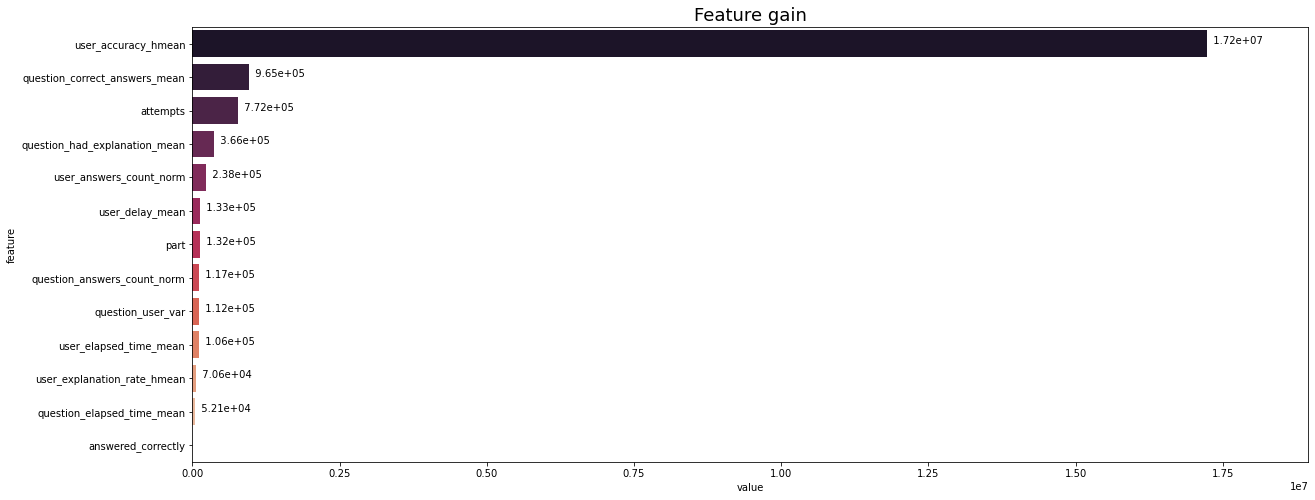

posx and posy should be finite values
posx and posy should be finite values


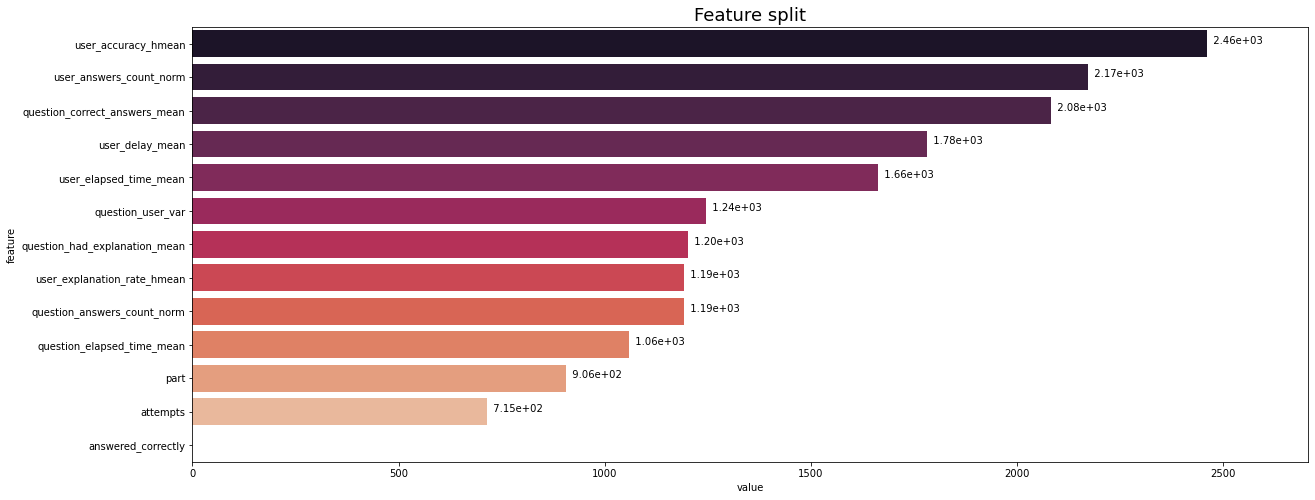

In [92]:
def show_feature_importances(model, importance_type, max_num_features=10**10):
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = train_df.columns
    feature_importances['value'] = pd.DataFrame(model.feature_importance(importance_type))
    feature_importances = feature_importances.sort_values(by='value', ascending=False) # sort feature importance
    feature_importances.to_csv(f'feature_importances_{importance_type}.csv') # write feature importance to csv
    feature_importances = feature_importances[:max_num_features] # only show max_num_features
    
    plt.figure(figsize=(20, 8))
    plt.xlim([0, feature_importances.value.max()*1.1])
    plt.title(f'Feature {importance_type}', fontsize=18);
    sns.barplot(data=feature_importances, x='value', y='feature', palette='rocket');
    for idx, v in enumerate(feature_importances.value):
        plt.text(v, idx, "  {:.2e}".format(v))

show_feature_importances(model, 'gain')
show_feature_importances(model, 'split')

In [85]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(valid_df)

SHAPError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580

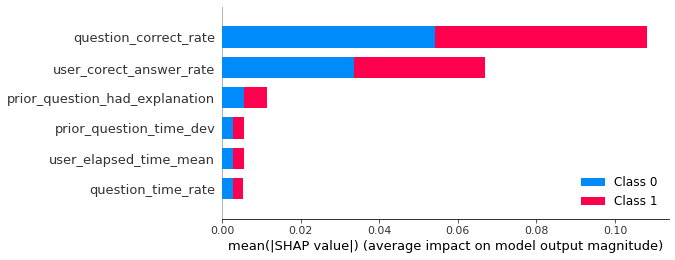

In [18]:
shap.summary_plot(shap_values, valid_features_df, plot_type="bar",
                  title = "")

# Predictions

In [23]:
import riiideducation
env = riiideducation.make_env()

ModuleNotFoundError: No module named 'riiideducation'

In [ ]:
# Here you would also add your pretrained model
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    # --- PREPROCESSING ---
    # Here is time to apply the preprocessing to the test_df
    test_df = merge_data(test_df, questions_df, data_type='test')
    test_df, last_answers = get_answer_time_characteristics(test_df, last_answers)
    test_df = get_features_df(test_df, q_chars, questions_df)
    
    # --- MODEL ---
    test_df['answered_correctly'] = lgbm_2.predict(test_df, num_iteration = lgbm_2.best_iteration)
    env.predict(test_df.reset_index()[['row_id', 'answered_correctly']])

In [32]:
df = pd.DataFrame({
    'a': ['1', '1', '1'],
    'b': [2, np.nan, np.nan]
})
df.drop_duplicates()

,a,b
0,1,2.0
1,1,NaN
